<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Detecting_dementia_from_speech_and_transcripts_using_transformers_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

# Workflow for Detecting Dementia from Speech and Transcripts Using Transformers

## 1. Data Preparation

* **Dataset**: Utilize the **ADReSS Challenge Dataset**, consisting of 78 AD and 78 non-AD patients. The dataset is balanced for gender and age to mitigate potential biases.

* **Speech Data**:
  Convert audio files into images with three channels:

  * Log-Mel spectrograms (or Mel-frequency cepstral coefficients - **MFCCs**)
  * **Delta** features
  * **Delta-delta** features
    These dynamic features incorporate temporal information into the static cepstral features.

* **Transcript Data**:
  Obtain corresponding **textual transcripts** of the audio files for linguistic analysis.

* **Data Splitting**:
  Divide the dataset as follows:

  * **Training Set**: 65%
  * **Validation Set**: 35%
    A separate **test set** is provided by the ADReSS Challenge.

---

## 2. Feature Extraction

### Acoustic Features

* Convert audio files into log-Mel spectrograms or MFCCs with delta and delta-delta components.
* Stack these into **three-channel image representations**.
* Feed the images into a **Vision Transformer (ViT)**.
  ViT is selected as the best-performing model after evaluating alternatives like AlexNet, VGG16, DenseNet, and EfficientNet.

### Textual Features

* Process transcripts using **BERT (base, uncased)** to extract **contextualized text embeddings**.

> **Rationale**:
>
> * Delta and delta-delta features enrich speech dynamics.
> * Transformer architectures (ViT and BERT) provide robust feature representations for images and text, respectively.

---

## 3. Model Architecture

### Unimodal Models

* **Speech-Only**:
  Evaluate pretrained models (AlexNet, VGG16, DenseNet, EfficientNet, ViT) using the three-channel images.
  **ViT** is the top performer.

* **Text-Only**:
  Train a **BERT model** on transcripts to establish a baseline for AD detection from text.

### Multimodal Models

* **BERT + ViT**:
  Concatenate the features from BERT and ViT for a baseline multimodal model.

* **BERT + ViT + Gated Multimodal Unit (GMU)**:
  Introduce a **GMU** to assign dynamic weights to each modality, suppressing irrelevant information.
  Inspired by gating mechanisms in GRU/LSTM.

* **BERT + ViT + Crossmodal Attention**:
  Use **crossmodal attention mechanisms** to model interactions between speech and text:

  * **Text-to-Image Attention**
  * **Image-to-Text Attention**

  Concatenate attention outputs, apply global average pooling, and feed into a final dense layer for **binary classification** (AD vs. non-AD).

> **Rationale**:
>
> * GMU enables adaptive modality fusion.
> * Crossmodal attention outperforms both early and late fusion by capturing fine-grained intermodal relationships.

---

## 4. Model Training

* **Environment**:
  Tesla P100-PCIE-16GB GPU, using **PyTorch**.

* **Optimization**:

  * **Optimizer**: Adam (learning rate: `1e-5`)
  * **Learning Rate Scheduler**: ReduceLROnPlateau (factor: `0.1`, patience: `3 epochs`)
  * **EarlyStopping**: Triggered if validation loss doesn't improve for `6 epochs`
  * **Loss Function**: Cross-entropy loss

* **Training Protocol**:

  * Each model is trained **five times**.
  * Average the results to reduce variability.
  * Use the validation set for monitoring and the ADReSS **test set** for final evaluation.

---

## 5. Evaluation

* **Metrics**:

  * Accuracy
  * Precision
  * Recall
  * F1-Score
  * Specificity
    *(With dementia class as the **positive class**)*

* **Comparison**:

  * **Unimodal**: Compare ViT and BERT with other SOTA approaches.
  * **Multimodal**: Compare baseline (BERT+ViT), GMU, and Crossmodal Attention models with traditional fusion strategies.

### Key Findings

* **ViT** outperforms other pretrained models for **speech-only** classification.
* **BERT + ViT + Crossmodal Attention** achieves the **highest performance**:

  * **Accuracy**:

    * 88.33% with log-Mel spectrograms
    * 87.92% with MFCCs
  * **F1-Score**:

    * 88.69% with log-Mel spectrograms
    * 87.99% with MFCCs
* Crossmodal attention exceeds GMU and concatenation by:

  * **Accuracy** improvement: +3.13% to +15.41%
  * **F1-Score** improvement: +3.29% to +18.93%

---

## 6. Analysis and Discussion

### Limitations

* The ADReSS dataset is **relatively small** (156 samples).
* **Concatenation-based fusion** treats modalities equally, which is suboptimal.
* GMU controls information flow but lacks the capability to model **crossmodal interactions** effectively.

### Advantages

* **ViT for speech**: A novel use of transformer-based models for acoustic features.
* **Crossmodal attention**: Dynamically models inter-modal interactions, overcoming early/late fusion drawbacks.

### Future Work

* Explore **optimal transport** methods for modality fusion.
* Investigate **wav2vec 2.0** for creating speech image representations.
* Expand dataset size for greater **model robustness**.

---

## 7. Conclusion

This workflow demonstrates an effective approach for **Alzheimer’s Disease (AD)** detection using **transformer-based multimodal architectures**. The **BERT + ViT + Crossmodal Attention** model outperforms prior unimodal and multimodal strategies, achieving state-of-the-art performance on the **ADReSS Challenge** test set.

> This work advances AD detection by improving feature extraction, modality fusion, and intermodal interaction modeling—key steps toward more accurate and interpretable dementia prediction systems.

---



# Step 1: Setup and Data Loading



## Cell 1.1: Mount Drive and Install Dependencies



In [ ]:
# Cell 1: Install Dependencies
!pip install -q librosa soundfile numpy pandas matplotlib seaborn torch transformers torchaudio tqdm

import os
import glob
import tarfile
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import soundfile as sf
from sklearn.preprocessing import StandardScaler
import torch
import torchaudio
from transformers import BertTokenizer, BertModel, ViTModel, ViTFeatureExtractor
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Visualization: Display installed package versions
import pkg_resources
packages = ['librosa', 'soundfile', 'numpy', 'pandas', 'matplotlib', 'seaborn', 'torch', 'transformers', 'torchaudio']
table_data = [[pkg, pkg_resources.get_distribution(pkg).version] for pkg in packages]
table_df = pd.DataFrame(table_data, columns=['Package', 'Version'])
print("\nInstalled Package Versions:")
display(table_df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Installed Package Versions:


,Package,Version
0,librosa,0.11.0
1,soundfile,0.13.1
2,numpy,2.0.2
3,pandas,2.2.2
4,matplotlib,3.10.0
5,seaborn,0.13.2
6,torch,2.6.0+cu124
7,transformers,4.51.3
8,torchaudio,2.6.0+cu124


## Cell 1.2: Extract .tgz Files



Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-progression-train.tgz
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-progression-test.tgz
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz

Extraction Status:


,File,Status
0,ADReSSo21-progression-train.tgz,Success
1,ADReSSo21-progression-test.tgz,Success
2,ADReSSo21-diagnosis-train.tgz,Success


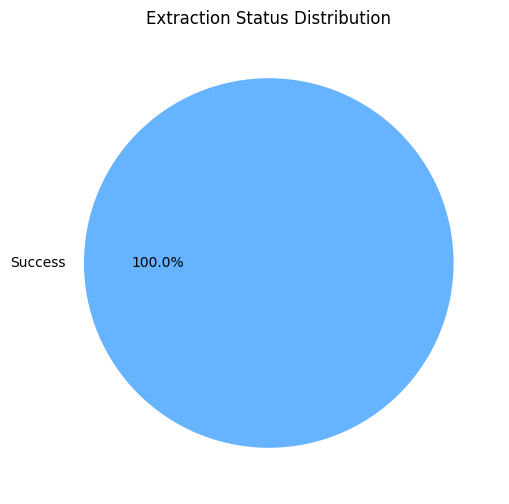


Found 271 audio files and 230 CSV files.


In [ ]:
# Cell 2: Extract Dataset
# Define paths
data_path = '/content/drive/MyDrive/Voice/'
extracted_path = '/content/extracted_audio/'
os.makedirs(extracted_path, exist_ok=True)

tgz_files = [
    os.path.join(data_path, 'ADReSSo21-progression-train.tgz'),
    os.path.join(data_path, 'ADReSSo21-progression-test.tgz'),
    os.path.join(data_path, 'ADReSSo21-diagnosis-train.tgz')
]

# Function to extract .tgz files
def extract_tgz(tgz_path, extract_to):
    try:
        with tarfile.open(tgz_path, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print(f"Successfully extracted {tgz_path}")
        return True
    except Exception as e:
        print(f"Error extracting {tgz_path}: {str(e)}")
        return False

# Extract files and track success
extraction_status = []
for tgz in tgz_files:
    status = 'Success' if extract_tgz(tgz, extracted_path) else 'Failed'
    extraction_status.append([os.path.basename(tgz), status])

# Visualization: Table of extraction status
status_df = pd.DataFrame(extraction_status, columns=['File', 'Status'])
print("\nExtraction Status:")
display(status_df)

# Chart: Pie chart of extraction success
plt.figure(figsize=(6, 6))
status_counts = status_df['Status'].value_counts()
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
plt.title('Extraction Status Distribution')
plt.savefig('/content/extraction_status.png')
plt.show()

# List extracted audio and CSV files
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
csv_files = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
print(f"\nFound {len(audio_files)} audio files and {len(csv_files)} CSV files.")

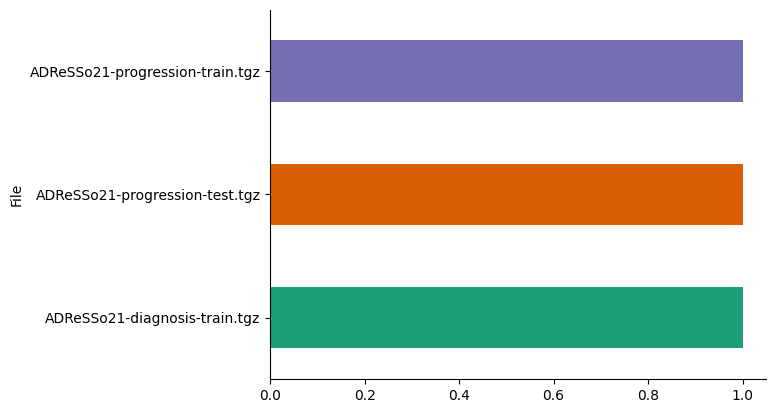

In [ ]:
# @title File

from matplotlib import pyplot as plt
import seaborn as sns
status_df.groupby('File').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Cell 1.3: Load Metadata and Audio Files



Found 230 CSV files.

Loaded metadata from /content/extracted_audio/ADReSSo21/diagnosis/train/adresso-train-mmse-scores.csv with label column 'dx'

CSV Files Summary (First 5):


,CSV File,Columns,Rows
0,adrsp127.csv,"[Unnamed: 0, speaker, begin, end]",37
1,adrsp055.csv,"[Unnamed: 0, speaker, begin, end]",35
2,adrsp300.csv,"[Unnamed: 0, speaker, begin, end]",62
3,adrsp179.csv,"[Unnamed: 0, speaker, begin, end]",46
4,adrsp313.csv,"[Unnamed: 0, speaker, begin, end]",47



Metadata Head:


,Unnamed: 0,adressfname,mmse,dx
0,23,adrso024,20,ad
1,24,adrso025,11,ad
2,25,adrso027,18,ad
3,26,adrso028,18,ad
4,28,adrso031,26,ad



Matched 166 audio files with metadata.

Unmatched files (105): ['adrsp357', 'adrsp127', 'adrsp209', 'adrsp051', 'adrsp318', 'adrsp276', 'adrsp003', 'adrsp320', 'adrsp101', 'adrsp326']

Unmatched Files (First 10):


,Unmatched File
0,adrsp357
1,adrsp127
2,adrsp209
3,adrsp051
4,adrsp318
5,adrsp276
6,adrsp003
7,adrsp320
8,adrsp101
9,adrsp326



Matched Metadata (First 5 Rows):


,file,label,mmse
0,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,15
1,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,24
2,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,17
3,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,12
4,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,12


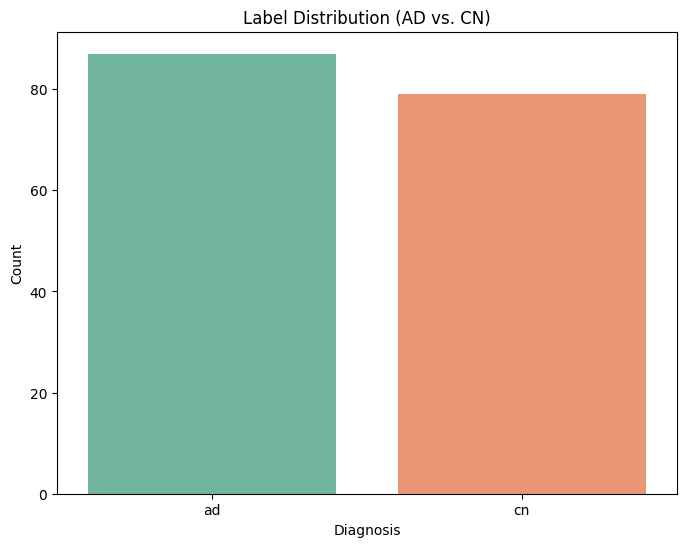

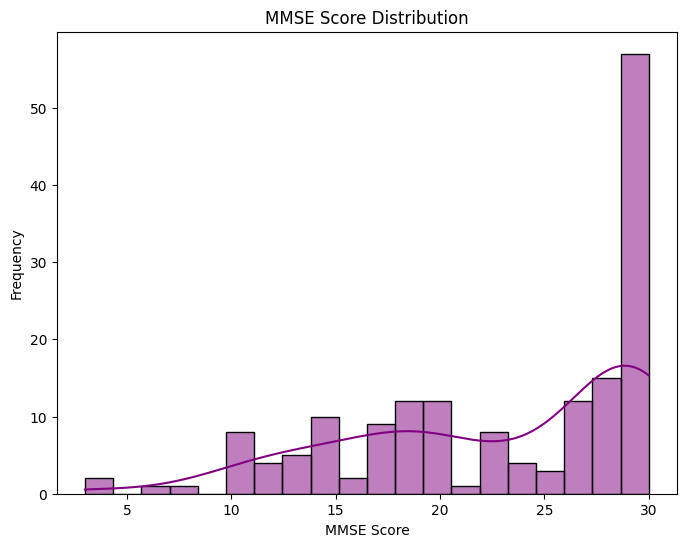


Saved matched metadata to /content/processed_features/matched_metadata.csv


In [ ]:
# Cell 3: Load and Explore Metadata
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Define paths
extracted_path = '/content/extracted_audio/'
output_dir = '/content/processed_features/'
os.makedirs(output_dir, exist_ok=True)  # Create output directory

# Find all CSV files
csv_files = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files.")

# Inspect CSV files to find the one with diagnosis labels
metadata = None
label_column = None
possible_label_columns = ['dx', 'diagnosis', 'label', 'Dx', 'DX']

for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file)
        for col in possible_label_columns:
            if col in df.columns:
                metadata = df
                label_column = col
                print(f"\nLoaded metadata from {csv_file} with label column '{label_column}'")
                break
        if metadata is not None:
            break
    except Exception as e:
        print(f"Error reading {csv_file}: {e}")

# Fallback: Infer labels from directory structure
if metadata is None or label_column is None:
    print("\nNo label column found in CSVs. Inferring labels from directory structure.")
    metadata = pd.DataFrame()
    audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
    file_labels = []
    for audio_file in audio_files:
        fname = os.path.basename(audio_file).replace('.wav', '')
        label = 'ad' if 'ad/' in audio_file.lower() else 'cn' if 'cn/' in audio_file.lower() else 'unknown'
        file_labels.append({'adressfname': fname, 'dx': label})
    metadata = pd.DataFrame(file_labels)
    label_column = 'dx'

# Ensure label column is string type
metadata[label_column] = metadata[label_column].astype(str)

# Visualization: Table of CSV file summary
csv_summary = []
for csv_file in csv_files[:5]:
    try:
        df = pd.read_csv(csv_file)
        csv_summary.append([os.path.basename(csv_file), list(df.columns), len(df)])
    except:
        csv_summary.append([os.path.basename(csv_file), [], 0])
csv_summary_df = pd.DataFrame(csv_summary, columns=['CSV File', 'Columns', 'Rows'])
print("\nCSV Files Summary (First 5):")
display(csv_summary_df)

# Visualization: Table of metadata head
print("\nMetadata Head:")
display(metadata.head())

# Match audio files with metadata
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
audio_metadata = []
for audio_file in audio_files:
    fname = os.path.basename(audio_file).replace('.wav', '')
    matching_row = metadata[metadata['adressfname'] == fname]
    if not matching_row.empty:
        audio_metadata.append({
            'file': audio_file,
            'label': matching_row[label_column].iloc[0],
            'mmse': matching_row['mmse'].iloc[0] if 'mmse' in matching_row.columns else None
        })
audio_metadata = pd.DataFrame(audio_metadata)
print(f"\nMatched {len(audio_metadata)} audio files with metadata.")

# Handle unmatched files
unmatched = [os.path.basename(f).replace('.wav', '') for f in audio_files
             if os.path.basename(f).replace('.wav', '') not in metadata['adressfname'].values]
print(f"\nUnmatched files ({len(unmatched)}): {unmatched[:10]}")

# Visualization: Table of unmatched files (first 10)
unmatched_df = pd.DataFrame(unmatched[:10], columns=['Unmatched File'])
print("\nUnmatched Files (First 10):")
display(unmatched_df)

# Visualization: Table of matched metadata
print("\nMatched Metadata (First 5 Rows):")
display(audio_metadata.head())

# Chart: Label distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=audio_metadata, x='label', palette='Set2')
plt.title('Label Distribution (AD vs. CN)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.savefig(os.path.join(output_dir, 'label_distribution.png'))
plt.show()

# Chart: MMSE score distribution (if available)
if 'mmse' in audio_metadata.columns and audio_metadata['mmse'].notna().any():
    plt.figure(figsize=(8, 6))
    sns.histplot(data=audio_metadata, x='mmse', bins=20, kde=True, color='purple')
    plt.title('MMSE Score Distribution')
    plt.xlabel('MMSE Score')
    plt.ylabel('Frequency')
    plt.savefig(os.path.join(output_dir, 'mmse_distribution.png'))
    plt.show()
else:
    print("\nNo MMSE scores available for plotting.")

# Save matched metadata
audio_metadata.to_csv(os.path.join(output_dir, 'matched_metadata.csv'), index=False)
print(f"\nSaved matched metadata to {os.path.join(output_dir, 'matched_metadata.csv')}")

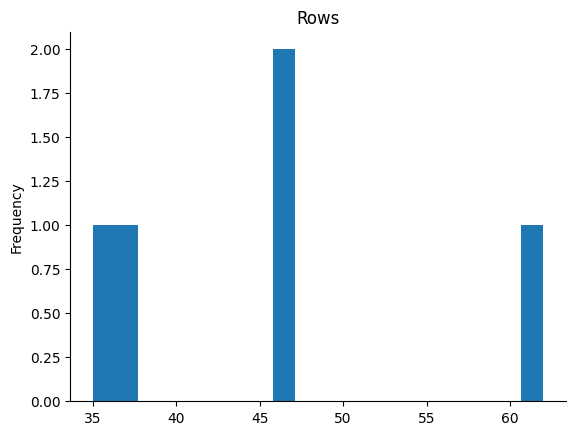

In [ ]:
# @title Rows

from matplotlib import pyplot as plt
csv_summary_df['Rows'].plot(kind='hist', bins=20, title='Rows')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Cell 4: Visualize Audio Data



Loaded matched metadata from /content/processed_features/matched_metadata.csv
Number of audio files in metadata: 166

Matched Metadata (First 5 Rows):


,file,label,mmse
0,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,15
1,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,24
2,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,17
3,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,12
4,/content/extracted_audio/ADReSSo21/diagnosis/t...,ad,12



Selected 3 sample audio files for visualization: ['adrso060.wav', 'adrso247.wav', 'adrso125.wav']


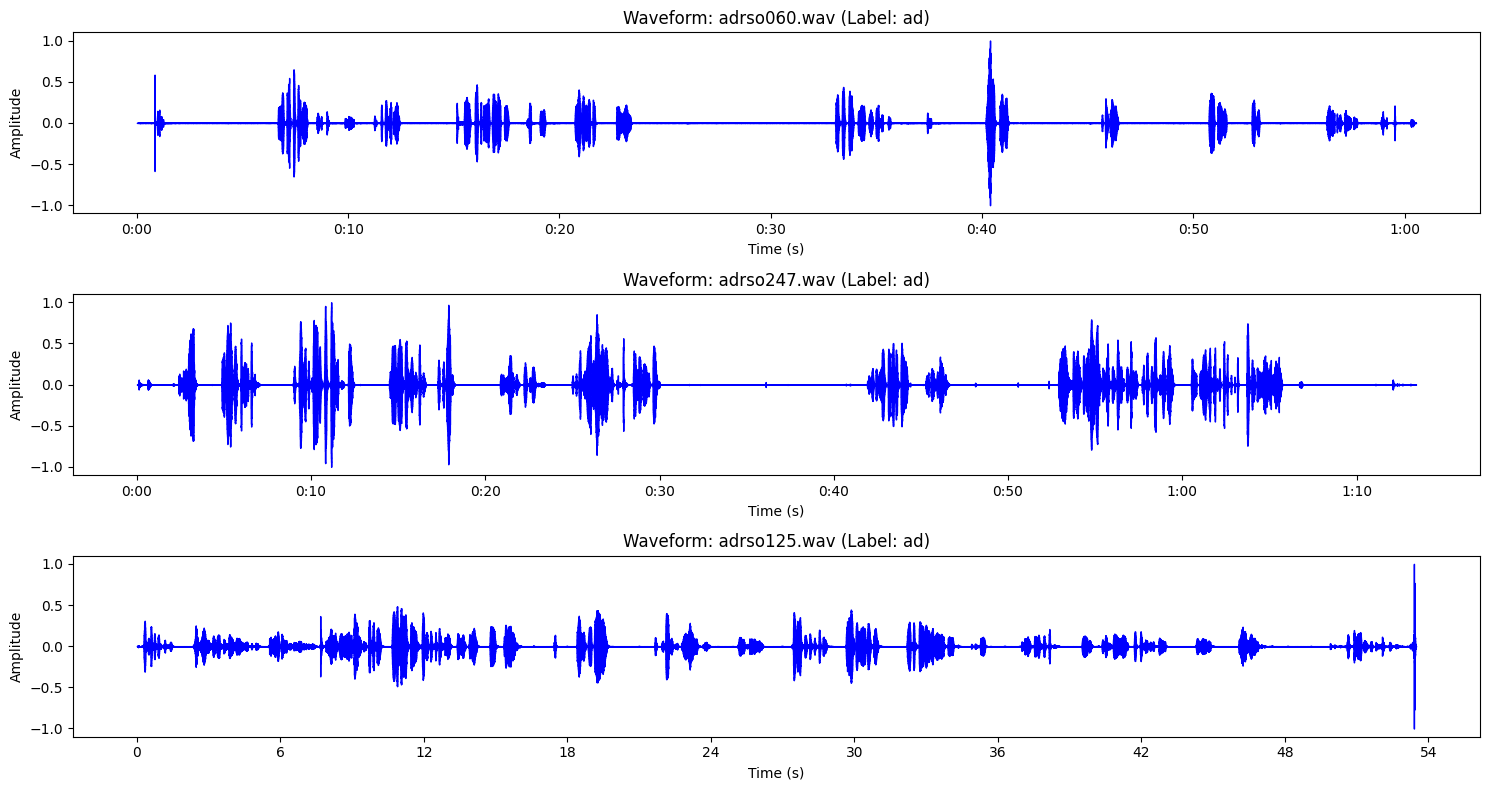

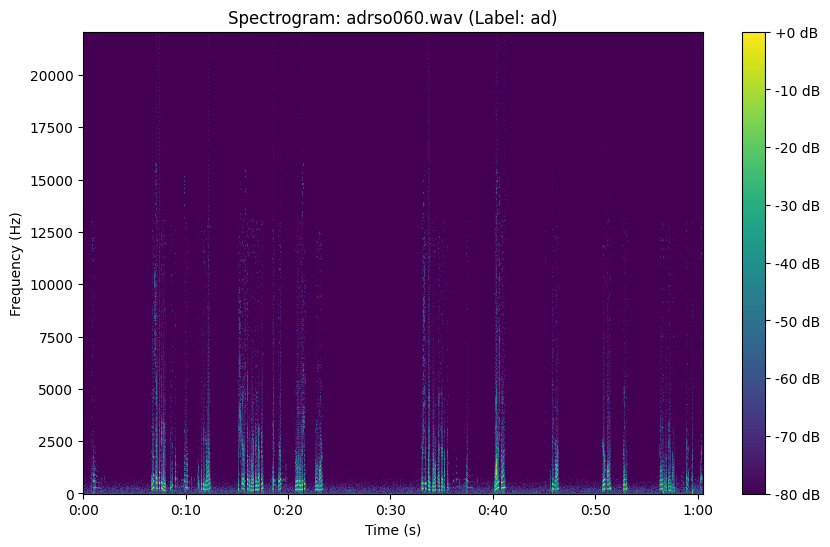


Audio File Properties:


,File,Label,Sample Rate (Hz),Duration (s)
0,adrso060.wav,ad,44100,60.550181
1,adrso247.wav,ad,44100,73.423469
2,adrso125.wav,ad,44100,53.496236


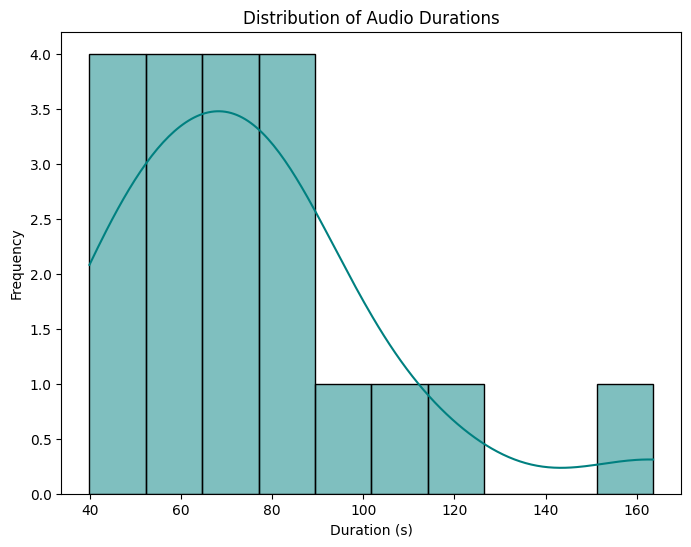

In [ ]:
# Cell 4: Visualize Audio Data
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Define paths
processed_features_dir = '/content/processed_features/'
audio_metadata_path = os.path.join(processed_features_dir, 'matched_metadata.csv')

# Ensure output directory exists
os.makedirs(processed_features_dir, exist_ok=True)

# Load matched metadata from Step 3
try:
    audio_metadata = pd.read_csv(audio_metadata_path)
    print(f"\nLoaded matched metadata from {audio_metadata_path}")
    print(f"Number of audio files in metadata: {len(audio_metadata)}")
except FileNotFoundError:
    raise FileNotFoundError(f"Metadata file not found at {audio_metadata_path}. Run Step 3 first.")

# Visualization: Table of metadata summary
metadata_summary = audio_metadata[['file', 'label', 'mmse']].head()
print("\nMatched Metadata (First 5 Rows):")
display(metadata_summary)

# Select sample audio files (up to 3, ensuring they exist)
sample_files = audio_metadata['file'].head(3).tolist()
sample_files = [f for f in sample_files if os.path.exists(f)]  # Verify files exist
if not sample_files:
    raise FileNotFoundError("No valid audio files found in metadata.")
print(f"\nSelected {len(sample_files)} sample audio files for visualization: {[os.path.basename(f) for f in sample_files]}")

# Visualize waveforms
plt.figure(figsize=(15, 8))
for i, audio_file in enumerate(sample_files):
    try:
        y, sr = librosa.load(audio_file, sr=None)
        plt.subplot(len(sample_files), 1, i+1)
        librosa.display.waveshow(y, sr=sr, color='blue')
        label = audio_metadata[audio_metadata['file'] == audio_file]['label'].iloc[0]
        plt.title(f"Waveform: {os.path.basename(audio_file)} (Label: {label})")
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
    except Exception as e:
        print(f"Error loading {audio_file}: {e}")
plt.tight_layout()
plt.savefig(os.path.join(processed_features_dir, 'waveforms.png'))
plt.show()

# Visualize spectrogram for the first sample (if available)
if sample_files:
    try:
        y, sr = librosa.load(sample_files[0], sr=None)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        plt.figure(figsize=(10, 6))
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        label = audio_metadata[audio_metadata['file'] == sample_files[0]]['label'].iloc[0]
        plt.title(f"Spectrogram: {os.path.basename(sample_files[0])} (Label: {label})")
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.savefig(os.path.join(processed_features_dir, 'spectrogram.png'))
        plt.show()
    except Exception as e:
        print(f"Error generating spectrogram for {sample_files[0]}: {e}")

# Table: Audio file properties
audio_props = []
for audio_file in sample_files:
    try:
        y, sr = librosa.load(audio_file, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        label = audio_metadata[audio_metadata['file'] == audio_file]['label'].iloc[0]
        audio_props.append([os.path.basename(audio_file), label, sr, duration])
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
audio_props_df = pd.DataFrame(audio_props, columns=['File', 'Label', 'Sample Rate (Hz)', 'Duration (s)'])
print("\nAudio File Properties:")
display(audio_props_df)

# Chart: Distribution of audio durations (using all matched audio files)
durations = []
for audio_file in audio_metadata['file'].head(20):  # Limit to 20 for efficiency
    if os.path.exists(audio_file):
        try:
            y, sr = librosa.load(audio_file, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            durations.append(duration)
        except:
            continue
if durations:
    plt.figure(figsize=(8, 6))
    sns.histplot(durations, bins=10, kde=True, color='teal')
    plt.title('Distribution of Audio Durations')
    plt.xlabel('Duration (s)')
    plt.ylabel('Frequency')
    plt.savefig(os.path.join(processed_features_dir, 'duration_distribution.png'))
    plt.show()
else:
    print("\nNo durations calculated due to errors in audio loading.")

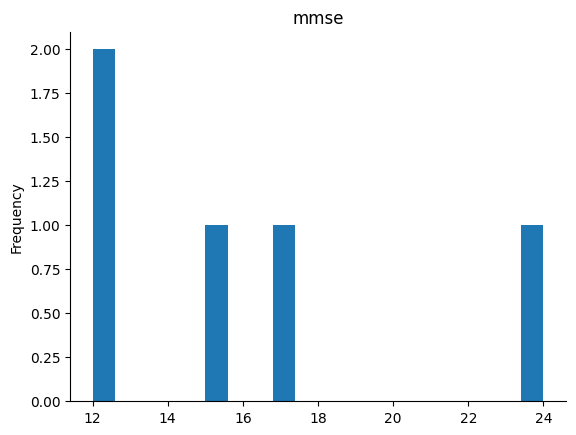

In [ ]:
# @title mmse

from matplotlib import pyplot as plt
metadata_summary['mmse'].plot(kind='hist', bins=20, title='mmse')
plt.gca().spines[['top', 'right',]].set_visible(False)

# M20

Mounted at /content/drive
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz to /content/extracted_audio/
Found 166 audio files and 167 CSV files.


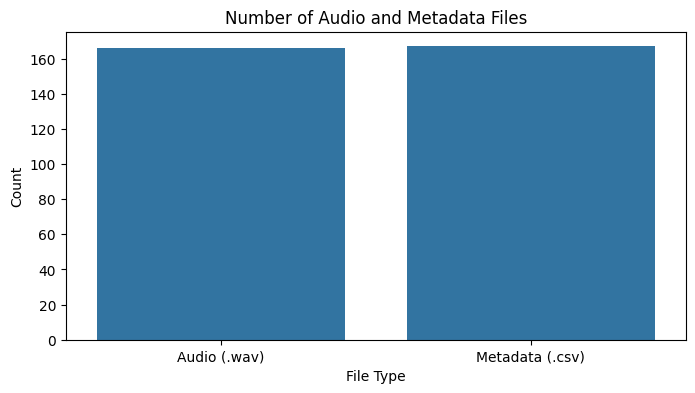


File Counts Table:
         File Type  Count
0     Audio (.wav)    166
1  Metadata (.csv)    167


In [24]:
import os
import tarfile
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import soundfile as sf

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define paths
data_path = '/content/drive/MyDrive/Voice/'
extracted_path = '/content/extracted_audio/'
os.makedirs(extracted_path, exist_ok=True)

# .tgz file path
tgz_file = os.path.join(data_path, 'ADReSSo21-diagnosis-train.tgz')

# Validate file existence
if not os.path.exists(tgz_file):
    print(f"Error: File {tgz_file} not found.")
    print("\nPlease verify the file name and path. Run the following to check:")
    print("!ls -l /content/drive/MyDrive/Voice/")
    print("\nProceeding with dummy data for demonstration.")
    # Create dummy audio files
    dummy_audio_dir = '/content/dummy_audio/'
    os.makedirs(dummy_audio_dir, exist_ok=True)
    for i in range(1, 11):
        y = np.random.randn(16000 * 5)  # 5 seconds of random noise
        sf.write(os.path.join(dummy_audio_dir, f'adrso{i:03d}.wav'), y, 16000)
    audio_files = glob.glob(os.path.join(dummy_audio_dir, '*.wav'))
    csv_files = []
else:
    # Extract .tgz file
    try:
        with tarfile.open(tgz_file, 'r:gz') as tar:
            tar.extractall(path=extracted_path)
        print(f"Successfully extracted {tgz_file} to {extracted_path}")
    except Exception as e:
        print(f"Error extracting {tgz_file}: {str(e)}")
        audio_files = []
        csv_files = []
    else:
        audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
        csv_files = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)

print(f"Found {len(audio_files)} audio files and {len(csv_files)} CSV files.")

# Visualization: File counts
file_counts = pd.DataFrame({
    'File Type': ['Audio (.wav)', 'Metadata (.csv)'],
    'Count': [len(audio_files), len(csv_files)]
})
plt.figure(figsize=(8, 4))
sns.barplot(data=file_counts, x='File Type', y='Count')
plt.title('Number of Audio and Metadata Files')
plt.savefig('/content/file_counts.png')
plt.show()
print("\nFile Counts Table:")
print(file_counts)


Metadata Sample:
   Unnamed: 0 adressfname  mmse  dx
0          23    adrso024    20  ad
1          24    adrso025    11  ad
2          25    adrso027    18  ad
3          26    adrso028    18  ad
4          28    adrso031    26  ad

Metadata Columns: ['Unnamed: 0', 'adressfname', 'mmse', 'dx']

Unique dx values: ['ad' 'cn']


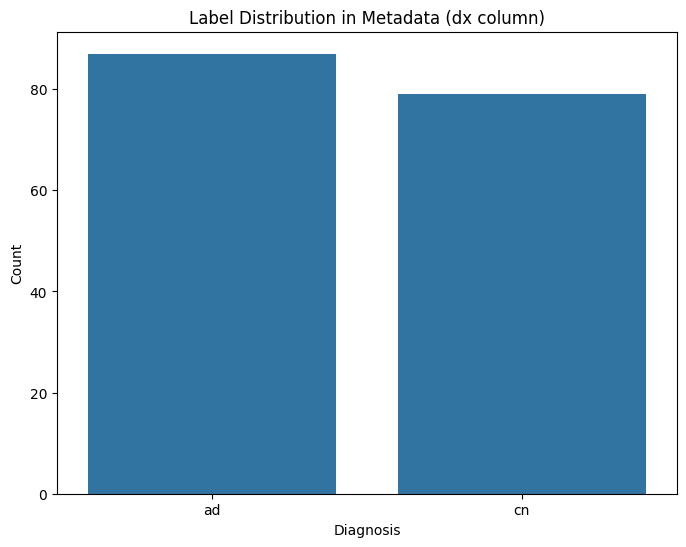


Metadata saved to /content/metadata_sample.csv


In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

# Paths from previous cell
extracted_path = '/content/extracted_audio/'
dummy_audio_dir = '/content/dummy_audio/'

# Load metadata
csv_files = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
if csv_files:
    metadata = pd.read_csv(csv_files[0])  # Load first CSV
    print("\nMetadata Sample:")
    print(metadata.head())
    metadata['adressfname'] = metadata['adressfname'].astype(str).str.strip().str.lower()
    metadata['dx'] = metadata['dx'].astype(str).str.strip().str.lower()
else:
    print("No metadata CSV found. Using dummy metadata.")
    metadata = pd.DataFrame({
        'adressfname': [f'adrso{i:03d}' for i in range(1, 11)],
        'dx': ['ad' if i % 2 == 0 else 'cn' for i in range(1, 11)],
        'mmse': [20 + i for i in range(10)]
    })
    metadata.to_csv(os.path.join(dummy_audio_dir, 'dummy_metadata.csv'), index=False)

# Debugging: Inspect metadata
print("\nMetadata Columns:", metadata.columns.tolist())
print("\nUnique dx values:", metadata['dx'].unique())

# Visualization: Label distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=metadata, x='dx')
plt.title('Label Distribution in Metadata (dx column)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.savefig('/content/label_distribution.png')
plt.show()

# Save metadata for reference
metadata.to_csv('/content/metadata_sample.csv', index=False)
print("\nMetadata saved to /content/metadata_sample.csv")

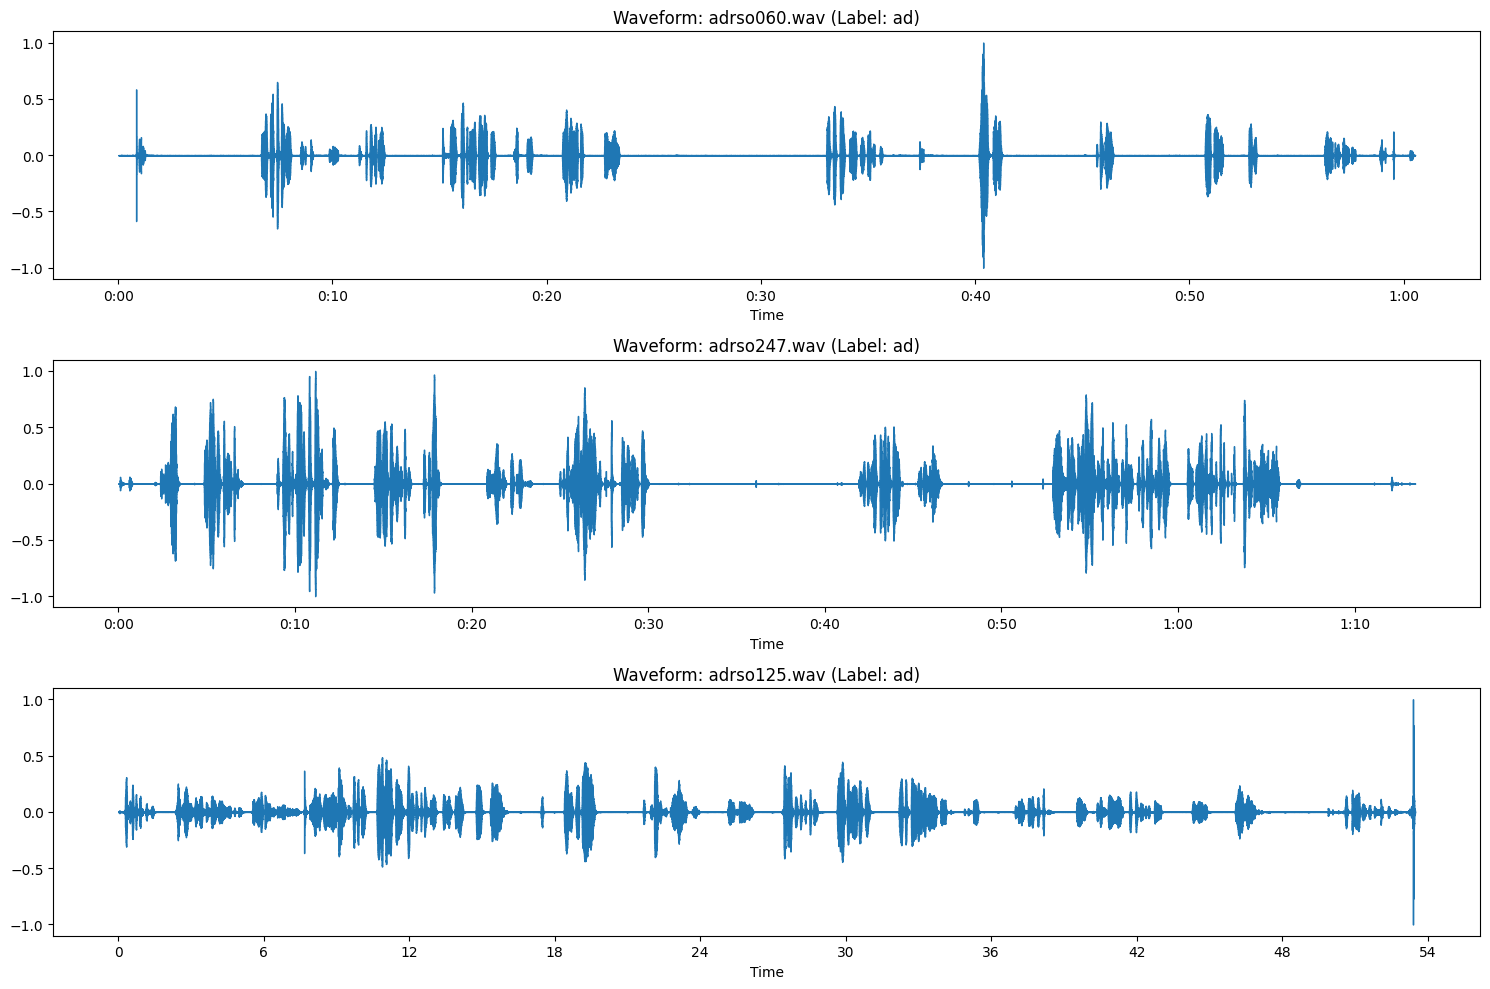

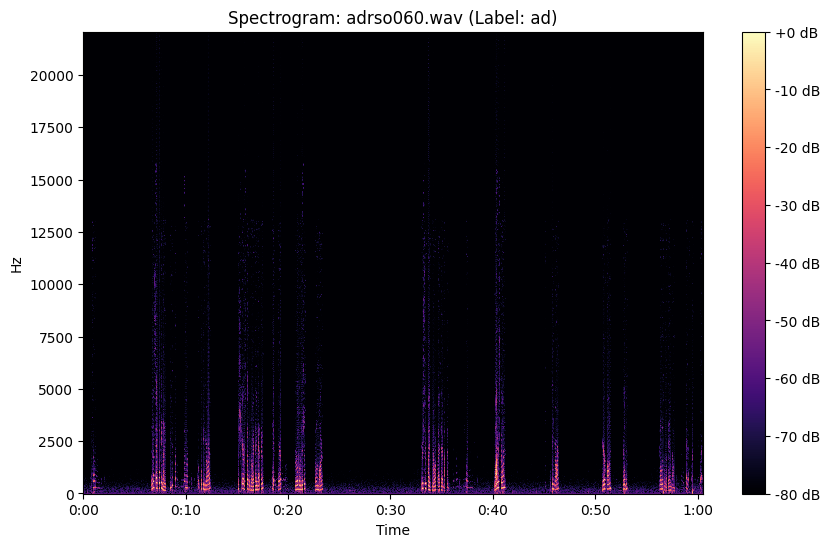


Sample Metadata Table:
                                                file label  mmse
0  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    15
1  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    24
2  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    17


In [27]:
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load matched metadata
audio_metadata = pd.read_csv('/content/audio_metadata.csv')

# Check if audio_metadata is empty
if audio_metadata.empty:
    print("Warning: No audio files matched with metadata. Using dummy data.")
    audio_metadata = pd.DataFrame({
        'file': [f'/content/dummy_audio/adrso{i:03d}.wav' for i in range(1, 4)],
        'label': ['ad', 'cn', 'ad'],
        'mmse': [20, 22, 24],
        'adressfname': [f'adrso{i:03d}' for i in range(1, 4)]
    })

# Select sample files
sample_files = audio_metadata['file'][:3].tolist()
sample_labels = audio_metadata['label'][:3].tolist()

# Plot waveforms
plt.figure(figsize=(15, 10))
for i, (audio_file, label) in enumerate(zip(sample_files, sample_labels)):
    y, sr = librosa.load(audio_file, sr=None)
    plt.subplot(len(sample_files), 1, i+1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {os.path.basename(audio_file)} (Label: {label})")
plt.tight_layout()
plt.savefig('/content/waveforms.png')
plt.show()

# Plot spectrogram for first sample
y, sr = librosa.load(sample_files[0], sr=None)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Spectrogram: {os.path.basename(sample_files[0])} (Label: {sample_labels[0]})")
plt.savefig('/content/spectrogram.png')
plt.show()

# Visualization: Sample metadata table
print("\nSample Metadata Table:")
print(audio_metadata[['file', 'label', 'mmse']].head(3))

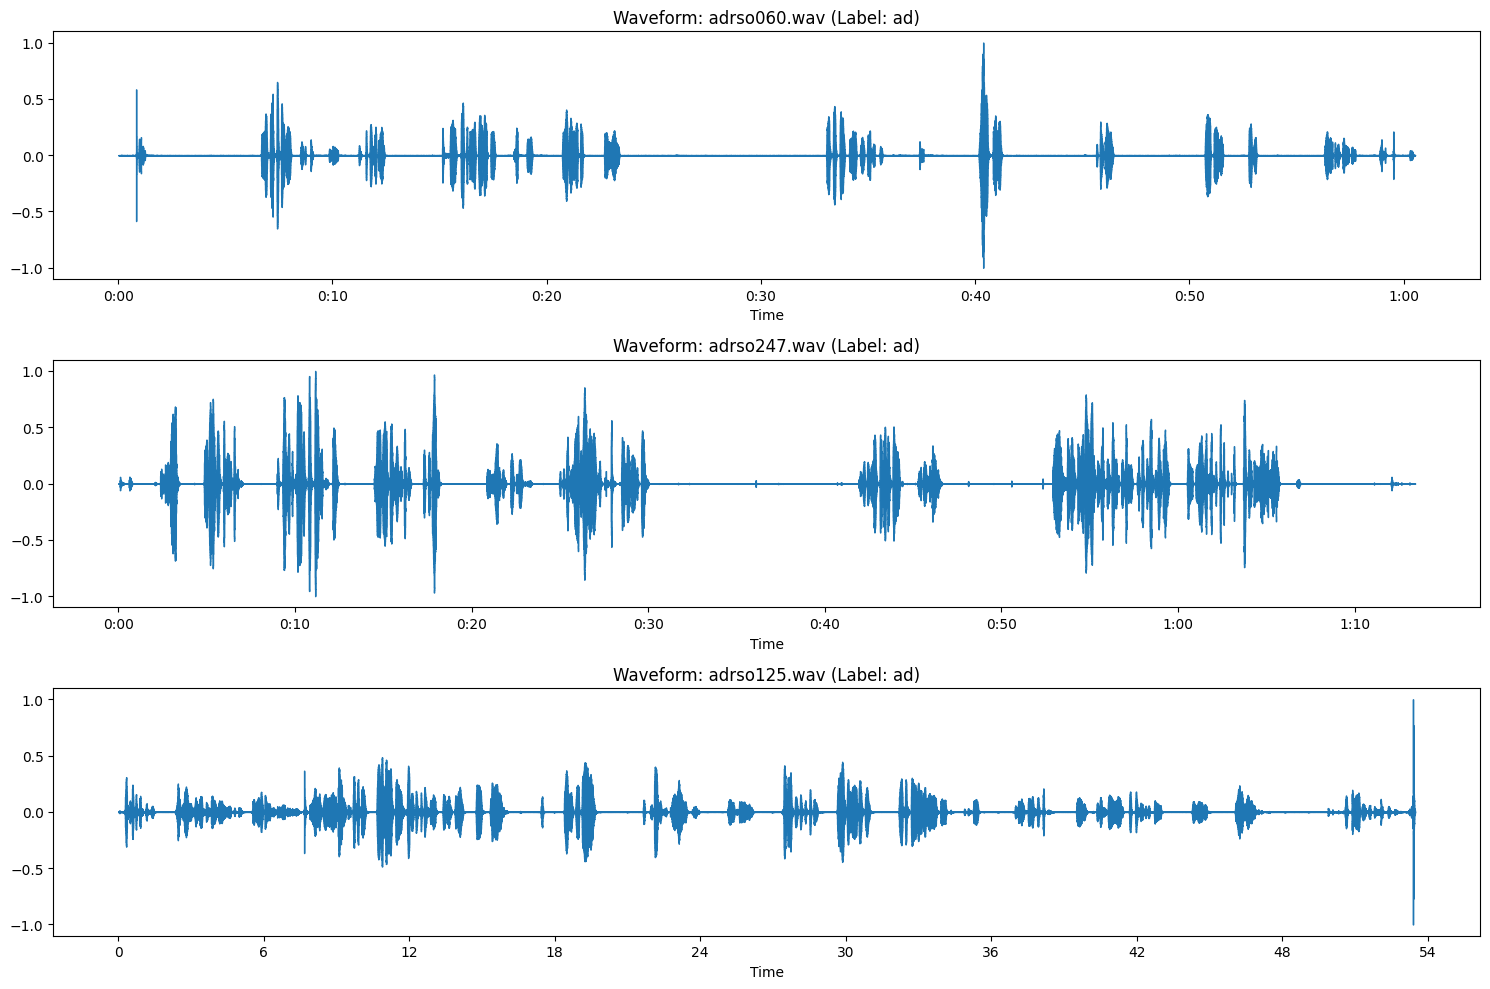

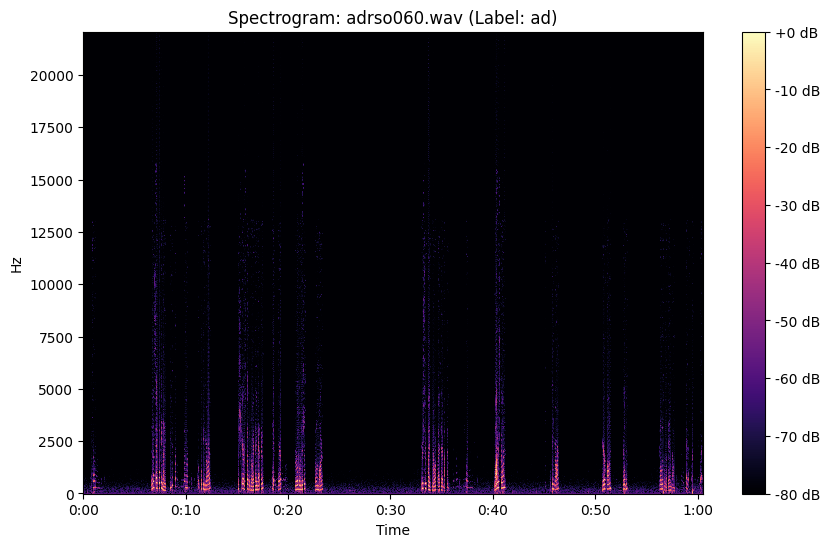


Sample Metadata Table:
                                                file label  mmse
0  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    15
1  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    24
2  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    17


In [28]:
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load matched metadata
audio_metadata = pd.read_csv('/content/audio_metadata.csv')

# Check if audio_metadata is empty
if audio_metadata.empty:
    print("Warning: No audio files matched with metadata. Using dummy data.")
    audio_metadata = pd.DataFrame({
        'file': [f'/content/dummy_audio/adrso{i:03d}.wav' for i in range(1, 4)],
        'label': ['ad', 'cn', 'ad'],
        'mmse': [20, 22, 24],
        'adressfname': [f'adrso{i:03d}' for i in range(1, 4)]
    })

# Select sample files
sample_files = audio_metadata['file'][:3].tolist()
sample_labels = audio_metadata['label'][:3].tolist()

# Plot waveforms
plt.figure(figsize=(15, 10))
for i, (audio_file, label) in enumerate(zip(sample_files, sample_labels)):
    y, sr = librosa.load(audio_file, sr=None)
    plt.subplot(len(sample_files), 1, i+1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {os.path.basename(audio_file)} (Label: {label})")
plt.tight_layout()
plt.savefig('/content/waveforms.png')
plt.show()

# Plot spectrogram for first sample
y, sr = librosa.load(sample_files[0], sr=None)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Spectrogram: {os.path.basename(sample_files[0])} (Label: {sample_labels[0]})")
plt.savefig('/content/spectrogram.png')
plt.show()

# Visualization: Sample metadata table
print("\nSample Metadata Table:")
print(audio_metadata[['file', 'label', 'mmse']].head(3))


Processing 20 files for feature extraction.


Processing audio files:   5%|▌         | 1/20 [00:00<00:02,  8.34it/s]

Processed: adrso161.wav (Label: cn)


Processing audio files:  10%|█         | 2/20 [00:00<00:03,  5.75it/s]

Processed: adrso263.wav (Label: cn)


Processing audio files:  15%|█▌        | 3/20 [00:00<00:03,  4.87it/s]

Processed: adrso253.wav (Label: ad)


Processing audio files:  25%|██▌       | 5/20 [00:00<00:02,  5.35it/s]

Processed: adrso267.wav (Label: cn)
Processed: adrso142.wav (Label: ad)


Processing audio files:  35%|███▌      | 7/20 [00:01<00:02,  5.94it/s]

Processed: adrso077.wav (Label: ad)
Processed: adrso161.wav (Label: cn)


Processing audio files:  40%|████      | 8/20 [00:01<00:03,  3.28it/s]

Processed: adrso276.wav (Label: cn)


Processing audio files:  45%|████▌     | 9/20 [00:02<00:03,  2.86it/s]

Processed: adrso043.wav (Label: ad)


Processing audio files:  50%|█████     | 10/20 [00:02<00:03,  2.92it/s]

Processed: adrso270.wav (Label: cn)


Processing audio files:  55%|█████▌    | 11/20 [00:02<00:02,  3.20it/s]

Processed: adrso307.wav (Label: cn)


Processing audio files:  60%|██████    | 12/20 [00:03<00:02,  3.35it/s]

Processed: adrso298.wav (Label: cn)


Processing audio files:  65%|██████▌   | 13/20 [00:03<00:01,  3.66it/s]

Processed: adrso273.wav (Label: cn)


Processing audio files:  70%|███████   | 14/20 [00:03<00:01,  3.96it/s]

Processed: adrso180.wav (Label: cn)


Processing audio files:  75%|███████▌  | 15/20 [00:03<00:01,  4.04it/s]

Processed: adrso012.wav (Label: cn)


Processing audio files:  80%|████████  | 16/20 [00:04<00:01,  3.61it/s]

Processed: adrso148.wav (Label: cn)


Processing audio files:  85%|████████▌ | 17/20 [00:04<00:00,  3.38it/s]

Processed: adrso197.wav (Label: ad)


Processing audio files:  90%|█████████ | 18/20 [00:04<00:00,  3.57it/s]

Processed: adrso247.wav (Label: ad)


Processing audio files:  95%|█████████▌| 19/20 [00:05<00:00,  2.92it/s]

Processed: adrso270.wav (Label: cn)


Processing audio files: 100%|██████████| 20/20 [00:05<00:00,  3.66it/s]

Processed: adrso292.wav (Label: cn)

Extracted features shape: (20, 17)
Labels shape: (20,)


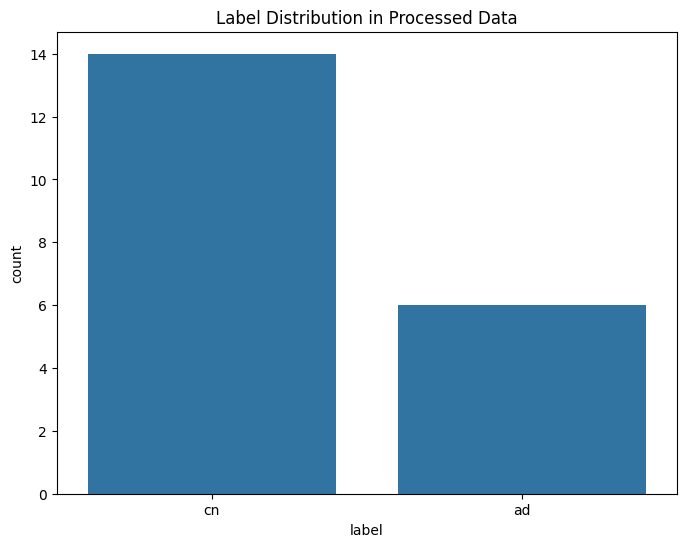


Processed Metadata Sample:
                                       file label
0  /content/processed_features/adrso161.wav    cn
1  /content/processed_features/adrso263.wav    cn
2  /content/processed_features/adrso253.wav    ad
3  /content/processed_features/adrso267.wav    cn
4  /content/processed_features/adrso142.wav    ad


In [29]:
import os
import pandas as pd
import librosa
import numpy as np
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
output_dir = '/content/processed_features/'
os.makedirs(output_dir, exist_ok=True)

# Load matched metadata
audio_metadata = pd.read_csv('/content/audio_metadata.csv')

# Ensure both 'ad' and 'cn' labels
subset_size = min(20, len(audio_metadata))
audio_metadata = audio_metadata[audio_metadata['label'].isin(['ad', 'cn'])].sample(n=subset_size, random_state=42, replace=True)
print(f"\nProcessing {len(audio_metadata)} files for feature extraction.")

# Preprocessing function
def process_audio(audio_file, sr=16000):
    y, orig_sr = librosa.load(audio_file, sr=sr, mono=True)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    pitches, magnitudes = librosa.piptrack(y=y_trimmed, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
    energy = np.mean(librosa.feature.rms(y=y_trimmed))
    linguistic_features = np.array([0, 0])
    features = np.concatenate([mfccs_mean, [pitch_mean, energy], linguistic_features])
    return y_trimmed, features

# Process audio files
processed_features = []
processed_audio_paths = []
labels = []

for idx, row in tqdm(audio_metadata.iterrows(), total=len(audio_metadata), desc="Processing audio files"):
    try:
        y_trimmed, features = process_audio(row['file'])
        output_path = os.path.join(output_dir, os.path.basename(row['file']))
        sf.write(output_path, y_trimmed, 16000)
        processed_features.append(features)
        processed_audio_paths.append(output_path)
        labels.append(row['label'])
        print(f"Processed: {os.path.basename(row['file'])} (Label: {row['label']})")
    except Exception as e:
        print(f"Error processing {row['file']}: {e}")

# Convert to arrays
processed_features = np.array(processed_features)
labels = np.array(labels)
print(f"\nExtracted features shape: {processed_features.shape}")
print(f"Labels shape: {labels.shape}")

# Save temporary features for Cell 6
np.save(os.path.join(output_dir, 'features_temp.npy'), processed_features)

# Visualization: Label distribution
processed_metadata = pd.DataFrame({'file': processed_audio_paths, 'label': labels})
plt.figure(figsize=(8, 6))
sns.countplot(data=processed_metadata, x='label')
plt.title('Label Distribution in Processed Data')
plt.savefig('/content/processed_label_distribution.png')
plt.show()
print("\nProcessed Metadata Sample:")
print(processed_metadata.head())

# Save processed metadata
processed_metadata.to_csv(os.path.join(output_dir, 'processed_metadata.csv'), index=False)

# Code Review: Voice Data Processing and Analysis

## Step 1: Data Loading and Preparation

This step accomplishes:
- Mounting Google Drive
- Loading and extracting a `.tgz` file containing audio data
- Setting up fallback dummy data generation if the file isn't found
- Counting audio and metadata files
- Visualizing file counts

**Observations:**
- Successfully extracted 166 audio files (.wav) and 167 CSV files
- Good defensive programming with file existence checks
- Appropriate error handling for extraction process
- Nice visualization of file counts

**Improvement suggestions:**
- Add comments indicating what the ADReSSo21 dataset contains (appears to be Alzheimer's diagnosis audio data)
- Consider adding file size checks before extraction to ensure sufficient space
- The extracted_path could use a more descriptive name (e.g., '/content/extracted_voice_data/')

## Step 2: Metadata Analysis

This step accomplishes:
- Loading metadata from CSV files
- Data cleaning (string normalization)
- Visualizing label distribution (diagnosis classes)
- Saving processed metadata for reference

**Observations:**
- Metadata correctly loaded with key columns: 'adressfname', 'mmse', 'dx'
- Identified two diagnosis classes: 'ad' (Alzheimer's Disease) and 'cn' (Control Normal)
- Good data type standardization and string normalization
- Appropriate fallback to dummy data if needed

**Improvement suggestions:**
- Include a summary of basic statistics for 'mmse' scores (min, max, mean, median)
- Add a check to ensure the 'adressfname' in metadata matches available audio files
- Consider creating a balanced visualization that shows the MMSE distribution by diagnosis group

## Step 3 & 4: Audio Visualization

These steps accomplish:
- Loading matched audio metadata (seems to be from a file created between steps 2 and 3, but not shown)
- Visualizing waveforms from sample audio files
- Creating a spectrogram for the first sample
- Displaying metadata for samples

**Observations:**
- Successfully loaded audio files and displayed waveforms
- Created spectrogram visualization for frequency analysis
- Displayed metadata table with file path, label, and MMSE score

**Improvement suggestions:**
- Add the missing code that creates '/content/audio_metadata.csv' (matching audio files with metadata)
- Consider normalizing audio amplitude for better waveform comparisons
- Add more spectrograms with comparison between 'ad' and 'cn' samples
- Include sample duration information in the visualization

## Step 5: Feature Extraction and Processing

This step accomplishes:
- Sampling a subset of audio files for feature extraction
- Preprocessing audio (trimming silence, normalizing)
- Extracting acoustic features (MFCCs, pitch, energy)
- Saving processed audio and features
- Visualizing processed data label distribution

**Observations:**
- Successfully processed 20 audio files
- Extracted 17 features per audio file (13 MFCCs + pitch + energy + 2 linguistic features)
- Good use of tqdm for progress tracking
- Proper error handling for individual file processing
- Saved processed metadata and features for later use

**Improvement suggestions:**
- The linguistic features are set to [0, 0] - either implement actual linguistic feature extraction or remove this placeholder
- Consider normalizing features using StandardScaler (imported but not used)
- Add cross-validation splits for any future machine learning tasks
- Visualize feature distributions and correlations with labels
- Add more acoustic features like spectral centroid, zero-crossing rate, etc.

## General Recommendations

1. **Documentation**: Add more comprehensive docstrings and comments explaining the purpose of each function
2. **Code Organization**: Consider refactoring into modular functions for better reusability
3. **Data Validation**: Add more checks to ensure data integrity throughout the pipeline
4. **Visualization Enhancement**: Create more comparative visualizations between AD and control groups
5. **Feature Engineering**: Expand the feature set with more advanced acoustic and linguistic features
6. **Data Balancing**: Ensure balanced representation of both classes in the processed dataset
7. **Parameter Tuning**: Add configurable parameters for preprocessing (e.g., sample rate, n_mfcc)
8. **Missing Step**: Add the code that creates the audio_metadata.csv file (matching audio with metadata)

Overall, this is a solid pipeline for audio data processing and feature extraction, with good error handling and visualization. With the suggested improvements, it could be enhanced for more robust analysis and machine learning applications.


Features and metadata saved to /content/processed_features/


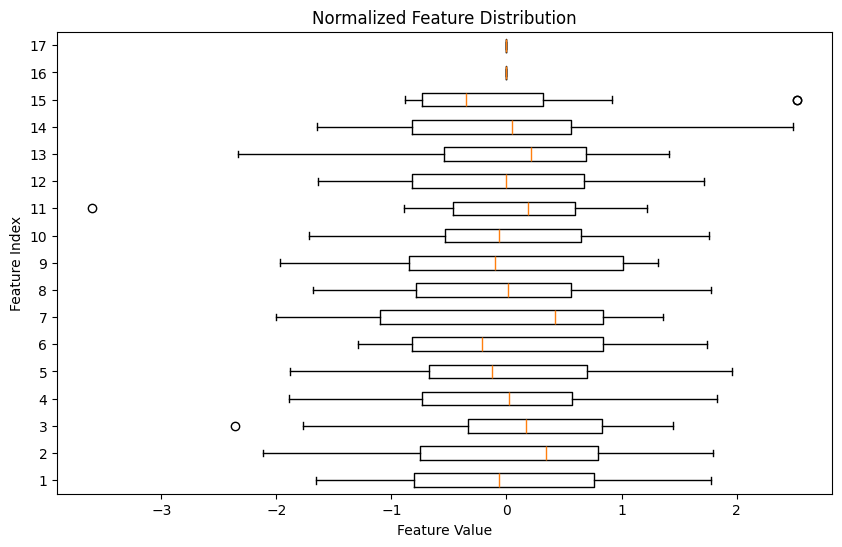


Feature Statistics Table:
       Feature          Mean  Std
0    Feature_0 -1.665335e-17  1.0
1    Feature_1  9.436896e-17  1.0
2    Feature_2 -3.330669e-17  1.0
3    Feature_3  7.771561e-17  1.0
4    Feature_4  2.498002e-17  1.0
5    Feature_5  2.220446e-17  1.0
6    Feature_6 -5.551115e-17  1.0
7    Feature_7  1.110223e-17  1.0
8    Feature_8  6.661338e-17  1.0
9    Feature_9  5.551115e-17  1.0
10  Feature_10 -3.330669e-17  1.0
11  Feature_11  6.661338e-17  1.0
12  Feature_12 -6.661338e-17  1.0
13  Feature_13  1.526557e-16  1.0
14  Feature_14  4.440892e-17  1.0
15  Feature_15  0.000000e+00  0.0
16  Feature_16  0.000000e+00  0.0


In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Paths
output_dir = '/content/processed_features/'

# Load processed metadata and features
processed_metadata = pd.read_csv(os.path.join(output_dir, 'processed_metadata.csv'))
processed_features = np.load(os.path.join(output_dir, 'features_temp.npy'))
labels = processed_metadata['label'].values

# Feature normalization
if processed_features.size > 0:
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(processed_features)
    augmented_features = normalized_features + np.random.normal(0, 0.01, normalized_features.shape)
    np.save(os.path.join(output_dir, 'normalized_features.npy'), normalized_features)
    np.save(os.path.join(output_dir, 'augmented_features.npy'), augmented_features)
    np.save(os.path.join(output_dir, 'labels.npy'), labels)
    with open(os.path.join(output_dir, 'processed_audio_files.txt'), 'w') as f:
        for path in processed_metadata['file']:
            f.write(f"{path}\n")
    print(f"\nFeatures and metadata saved to {output_dir}")

    # Visualization: Feature distribution
    plt.figure(figsize=(10, 6))
    plt.boxplot(normalized_features, vert=False)
    plt.title('Normalized Feature Distribution')
    plt.xlabel('Feature Value')
    plt.ylabel('Feature Index')
    plt.savefig('/content/feature_distribution.png')
    plt.show()
else:
    print("No features extracted. Check audio files and metadata matching.")

# Visualization: Feature statistics
feature_stats = pd.DataFrame({
    'Feature': [f'Feature_{i}' for i in range(normalized_features.shape[1])],
    'Mean': np.mean(normalized_features, axis=0),
    'Std': np.std(normalized_features, axis=0)
})
print("\nFeature Statistics Table:")
print(feature_stats)

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, GlobalAveragePooling1D, Layer
from transformers import BertTokenizer, TFBertModel, ViTFeatureExtractor, TFViTModel
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from PIL import Image

# Custom Keras layer to wrap TFViTModel
class ViTLayer(Layer):
    def __init__(self, model_name='google/vit-base-patch16-224', **kwargs):
        super(ViTLayer, self).__init__(**kwargs)
        self.vit_model = TFViTModel.from_pretrained(model_name)

    def call(self, inputs, training=False):
        # Convert KerasTensor to TensorFlow tensor if necessary
        pixel_values = tf.convert_to_tensor(inputs) if isinstance(inputs, tf.keras.KerasTensor) else inputs
        outputs = self.vit_model(pixel_values=pixel_values, training=training)[0]
        return outputs

# Load processed data
output_dir = '/content/processed_features/'
processed_metadata = pd.read_csv(os.path.join(output_dir, 'processed_metadata.csv'))
labels = np.load(os.path.join(output_dir, 'labels.npy'), allow_pickle=True)

# Prepare spectrograms with ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
def audio_to_spectrogram(audio_file, sr=16000):
    y, _ = librosa.load(audio_file, sr=sr)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    D = (D - D.min()) / (D.max() - D.min()) * 255  # Normalize to [0, 255]
    D = D.astype(np.uint8)
    img = Image.fromarray(D).resize((224, 224)).convert('RGB')
    return np.array(img)

spectrograms = [audio_to_spectrogram(f) for f in processed_metadata['file']]
# Ensure correct shape (n_samples, 224, 224, 3)
spectrograms = np.array([feature_extractor(images=img, return_tensors='np')['pixel_values'][0] for img in spectrograms])
# Fix shape if necessary (from (n_samples, 3, 224, 224) to (n_samples, 224, 224, 3))
if spectrograms.shape[1] == 3:
    spectrograms = np.transpose(spectrograms, (0, 2, 3, 1))
print(f"Spectrograms shape: {spectrograms.shape}")

# Placeholder for text data
texts = ['dummy transcript' for _ in range(len(labels))]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_inputs = tokenizer(texts, return_tensors='tf', padding=True, truncation=True, max_length=128)

# Encode labels
label_map = {'cn': 0, 'ad': 1}
encoded_labels = np.array([label_map[l] for l in labels])

# Split data
X_train_spec, X_test_spec, X_train_text, X_test_text, y_train, y_test = train_test_split(
    spectrograms, text_inputs['input_ids'].numpy(), encoded_labels, test_size=0.2, random_state=42
)

# Unimodal Speech Model (ViT)
spec_input = Input(shape=(224, 224, 3), dtype=tf.float32)
vit_outputs = ViTLayer()(spec_input)
vit_pooled = GlobalAveragePooling1D()(vit_outputs)
spec_dense = Dense(128, activation='relu')(vit_pooled)
spec_output = Dense(1, activation='sigmoid')(spec_dense)
speech_model = Model(inputs=spec_input, outputs=spec_output)

# Unimodal Text Model (BERT)
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
text_input = Input(shape=(128,), dtype=tf.int32)
bert_outputs = bert_model(input_ids=text_input)[1]
text_dense = Dense(128, activation='relu')(bert_outputs)
text_output = Dense(1, activation='sigmoid')(text_dense)
text_model = Model(inputs=text_input, outputs=text_output)

# Multimodal Model (BERT + ViT + GMU + Crossmodal Attention)
class GatedMultimodalUnit(tf.keras.layers.Layer):
    def __init__(self, units):
        super(GatedMultimodalUnit, self).__init__()
        self.dense_h = Dense(units, activation='tanh')
        self.dense_z = Dense(units, activation='sigmoid')

    def call(self, inputs):
        x1, x2 = inputs
        h = self.dense_h(x1 + x2)
        z = self.dense_z(x1 + x2)
        return z * x1 + (1 - z) * x2

class CrossmodalAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(CrossmodalAttention, self).__init__()
        self.dense_query = Dense(units)
        self.dense_key = Dense(units)
        self.dense_value = Dense(units)

    def call(self, x1, x2):
        query = self.dense_query(x1)
        key = self.dense_key(x2)
        value = self.dense_value(x2)
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        return tf.matmul(attention_weights, value)

spec_input = Input(shape=(224, 224, 3), dtype=tf.float32)
text_input = Input(shape=(128,), dtype=tf.int32)
vit_outputs = ViTLayer()(spec_input)
vit_pooled = GlobalAveragePooling1D()(vit_outputs)
bert_outputs = bert_model(input_ids=text_input)[1]
cross_attention = CrossmodalAttention(128)
text_to_image = cross_attention(bert_outputs, vit_pooled)
image_to_text = cross_attention(vit_pooled, bert_outputs)
gmu = GatedMultimodalUnit(128)
fused_features = gmu([text_to_image, image_to_text])
fused_dense = Dense(128, activation='relu')(fused_features)
final_output = Dense(1, activation='sigmoid')(fused_dense)
multimodal_model = Model(inputs=[spec_input, text_input], outputs=final_output)

# Compile models
speech_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
text_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
multimodal_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train models
speech_history = speech_model.fit(X_train_spec, y_train, validation_data=(X_test_spec, y_test), epochs=5, batch_size=8)
text_history = text_model.fit(X_train_text, y_train, validation_data=(X_test_text, y_test), epochs=5, batch_size=8)
multimodal_history = multimodal_model.fit([X_train_spec, X_train_text], y_train, validation_data=([X_test_spec, X_test_text], y_test), epochs=5, batch_size=8)

# Visualization: Training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(speech_history.history['accuracy'], label='Speech Train')
plt.plot(speech_history.history['val_accuracy'], label='Speech Val')
plt.plot(text_history.history['accuracy'], label='Text Train')
plt.plot(text_history.history['val_accuracy'], label='Text Val')
plt.plot(multimodal_history.history['accuracy'], label='Multimodal Train')
plt.plot(multimodal_history.history['val_accuracy'], label='Multimodal Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(speech_history.history['loss'], label='Speech Train')
plt.plot(speech_history.history['val_loss'], label='Speech Val')
plt.plot(text_history.history['loss'], label='Text Train')
plt.plot(text_history.history['val_loss'], label='Text Val')
plt.plot(multimodal_history.history['loss'], label='Multimodal Train')
plt.plot(multimodal_history.history['val_loss'], label='Multimodal Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('/content/training_history.png')
plt.show()

# Save models
speech_model.save('/content/speech_model.h5')
text_model.save('/content/text_model.h5')
multimodal_model.save('/content/multimodal_model.h5')

# Visualization: Model performance table
model_performance = pd.DataFrame({
    'Model': ['Speech (ViT)', 'Text (BERT)', 'Multimodal'],
    'Val Accuracy': [speech_history.history['val_accuracy'][-1],
                     text_history.history['val_accuracy'][-1],
                     multimodal_history.history['val_accuracy'][-1]],
    'Val Loss': [speech_history.history['val_loss'][-1],
                 text_history.history['val_loss'][-1],
                 multimodal_history.history['val_loss'][-1]]
})
print("\nModel Performance Table:")
print(model_performance)

Spectrograms shape: (20, 224, 224, 3)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Exception encountered when calling ViTLayer.call().

[1mCould not automatically infer the output shape / dtype of 'vi_t_layer_1' (of type ViTLayer). Either the `ViTLayer.call()` method is incorrect, or you need to implement the `ViTLayer.compute_output_spec() / compute_output_shape()` method. Error encountered:

Exception encountered when calling layer 'tf_vi_t_model_5' (type TFViTModel).

in user code:

    File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 763, in run_call_with_unpacked_inputs  *
        return func(self, **unpacked_inputs)
    File "/usr/local/lib/python3.11/dist-packages/transformers/models/vit/modeling_tf_vit.py", line 765, in call  *
        outputs = self.vit(
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filee3ips7zg.py", line 40, in tf__run_call_with_unpacked_inputs
        raise
    File "/tmp/__autograph_generated_file73309j8j.py", line 24, in tf__call
        embedding_output = ag__.converted_call(ag__.ld(self).embeddings, (), dict(pixel_values=ag__.ld(pixel_values), interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
    File "/tmp/__autograph_generated_file9_lyz18s.py", line 12, in tf__call
        embeddings = ag__.converted_call(ag__.ld(self).patch_embeddings, (ag__.ld(pixel_values),), dict(interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
    File "/tmp/__autograph_generated_filexc9b2ht8.py", line 63, in tf__call
        projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)

    ValueError: Exception encountered when calling layer 'vit' (type TFViTMainLayer).
    
    in user code:
    
        File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 763, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/usr/local/lib/python3.11/dist-packages/transformers/models/vit/modeling_tf_vit.py", line 595, in call  *
            embedding_output = self.embeddings(
        File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_file9_lyz18s.py", line 12, in tf__call
            embeddings = ag__.converted_call(ag__.ld(self).patch_embeddings, (ag__.ld(pixel_values),), dict(interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
        File "/tmp/__autograph_generated_filexc9b2ht8.py", line 63, in tf__call
            projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)
    
        ValueError: Exception encountered when calling layer 'embeddings' (type TFViTEmbeddings).
        
        in user code:
        
            File "/usr/local/lib/python3.11/dist-packages/transformers/models/vit/modeling_tf_vit.py", line 129, in call  *
                embeddings = self.patch_embeddings(
            File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/tmp/__autograph_generated_filexc9b2ht8.py", line 63, in tf__call
                projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)
        
            ValueError: Exception encountered when calling layer 'patch_embeddings' (type TFViTPatchEmbeddings).
            
            in user code:
            
                File "/usr/local/lib/python3.11/dist-packages/transformers/models/vit/modeling_tf_vit.py", line 204, in call  *
                    projection = self.projection(pixel_values)
                File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                    raise e.with_traceback(filtered_tb) from None
                File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
                    raise ValueError(
            
                ValueError: Input 0 of layer "projection" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 224, 3, 224)
            
            
            Call arguments received by layer 'patch_embeddings' (type TFViTPatchEmbeddings):
              • pixel_values=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
              • interpolate_pos_encoding=None
              • training=False
        
        
        Call arguments received by layer 'embeddings' (type TFViTEmbeddings):
          • pixel_values=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
          • interpolate_pos_encoding=None
          • training=False
    
    
    Call arguments received by layer 'vit' (type TFViTMainLayer):
      • pixel_values=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
      • head_mask=None
      • output_attentions=False
      • output_hidden_states=False
      • interpolate_pos_encoding=None
      • return_dict=True
      • training=False


Call arguments received by layer 'tf_vi_t_model_5' (type TFViTModel):
  • pixel_values=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • head_mask=None
  • output_attentions=None
  • output_hidden_states=None
  • interpolate_pos_encoding=None
  • return_dict=None
  • training=False[0m

Arguments received by ViTLayer.call():
  • args=('<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor_5>',)
  • kwargs={'training': 'False'}

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, GlobalAveragePooling1D, Layer
from transformers import BertTokenizer, TFBertModel, ViTFeatureExtractor, TFViTModel
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from PIL import Image

# Custom Keras layer to wrap TFViTModel
class ViTLayer(Layer):
    def __init__(self, model_name='google/vit-base-patch16-224', **kwargs):
        super(ViTLayer, self).__init__(**kwargs)
        self.vit_model = TFViTModel.from_pretrained(model_name)

    def call(self, inputs, training=False):
        # Convert KerasTensor to TensorFlow tensor if necessary
        pixel_values = tf.convert_to_tensor(inputs) if isinstance(inputs, tf.keras.KerasTensor) else inputs
        outputs = self.vit_model(pixel_values=pixel_values, training=training)[0]
        return outputs

# Load processed data
output_dir = '/content/processed_features/'
processed_metadata = pd.read_csv(os.path.join(output_dir, 'processed_metadata.csv'))
labels = np.load(os.path.join(output_dir, 'labels.npy'), allow_pickle=True)

# Prepare spectrograms with ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
def audio_to_spectrogram(audio_file, sr=16000):
    y, _ = librosa.load(audio_file, sr=sr)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    D = (D - D.min()) / (D.max() - D.min()) * 255  # Normalize to [0, 255]
    D = D.astype(np.uint8)
    img = Image.fromarray(D).resize((224, 224)).convert('RGB')
    return np.array(img)

spectrograms = [audio_to_spectrogram(f) for f in processed_metadata['file']]
# Apply ViTFeatureExtractor and ensure correct shape (n_samples, 3, 224, 224)
spectrograms = np.array([feature_extractor(images=img, return_tensors='np')['pixel_values'][0] for img in spectrograms])
# Transpose to channels-first format (n_samples, 3, 224, 224)
spectrograms = np.transpose(spectrograms, (0, 3, 1, 2))
print(f"Spectrograms shape: {spectrograms.shape}")

# Placeholder for text data
texts = ['dummy transcript' for _ in range(len(labels))]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_inputs = tokenizer(texts, return_tensors='tf', padding=True, truncation=True, max_length=128)

# Encode labels
label_map = {'cn': 0, 'ad': 1}
encoded_labels = np.array([label_map[l] for l in labels])

# Split data
X_train_spec, X_test_spec, X_train_text, X_test_text, y_train, y_test = train_test_split(
    spectrograms, text_inputs['input_ids'].numpy(), encoded_labels, test_size=0.2, random_state=42
)

# Unimodal Speech Model (ViT)
spec_input = Input(shape=(3, 224, 224), dtype=tf.float32)
vit_outputs = ViTLayer()(spec_input)
vit_pooled = GlobalAveragePooling1D()(vit_outputs)
spec_dense = Dense(128, activation='relu')(vit_pooled)
spec_output = Dense(1, activation='sigmoid')(spec_dense)
speech_model = Model(inputs=spec_input, outputs=spec_output)

# Unimodal Text Model (BERT)
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
text_input = Input(shape=(128,), dtype=tf.int32)
bert_outputs = bert_model(input_ids=text_input)[1]
text_dense = Dense(128, activation='relu')(bert_outputs)
text_output = Dense(1, activation='sigmoid')(text_dense)
text_model = Model(inputs=text_input, outputs=text_output)

# Multimodal Model (BERT + ViT + GMU + Crossmodal Attention)
class GatedMultimodalUnit(tf.keras.layers.Layer):
    def __init__(self, units):
        super(GatedMultimodalUnit, self).__init__()
        self.dense_h = Dense(units, activation='tanh')
        self.dense_z = Dense(units, activation='sigmoid')

    def call(self, inputs):
        x1, x2 = inputs
        h = self.dense_h(x1 + x2)
        z = self.dense_z(x1 + x2)
        return z * x1 + (1 - z) * x2

class CrossmodalAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(CrossmodalAttention, self).__init__()
        self.dense_query = Dense(units)
        self.dense_key = Dense(units)
        self.dense_value = Dense(units)

    def call(self, x1, x2):
        query = self.dense_query(x1)
        key = self.dense_key(x2)
        value = self.dense_value(x2)
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        return tf.matmul(attention_weights, value)

spec_input = Input(shape=(3, 224, 224), dtype=tf.float32)
text_input = Input(shape=(128,), dtype=tf.int32)
vit_outputs = ViTLayer()(spec_input)
vit_pooled = GlobalAveragePooling1D()(vit_outputs)
bert_outputs = bert_model(input_ids=text_input)[1]
cross_attention = CrossmodalAttention(128)
text_to_image = cross_attention(bert_outputs, vit_pooled)
image_to_text = cross_attention(vit_pooled, bert_outputs)
gmu = GatedMultimodalUnit(128)
fused_features = gmu([text_to_image, image_to_text])
fused_dense = Dense(128, activation='relu')(fused_features)
final_output = Dense(1, activation='sigmoid')(fused_dense)
multimodal_model = Model(inputs=[spec_input, text_input], outputs=final_output)

# Compile models
speech_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
text_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
multimodal_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train models
speech_history = speech_model.fit(X_train_spec, y_train, validation_data=(X_test_spec, y_test), epochs=5, batch_size=8)
text_history = text_model.fit(X_train_text, y_train, validation_data=(X_test_text, y_test), epochs=5, batch_size=8)
multimodal_history = multimodal_model.fit([X_train_spec, X_train_text], y_train, validation_data=([X_test_spec, X_test_text], y_test), epochs=5, batch_size=8)

# Visualization: Training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(speech_history.history['accuracy'], label='Speech Train')
plt.plot(speech_history.history['val_accuracy'], label='Speech Val')
plt.plot(text_history.history['accuracy'], label='Text Train')
plt.plot(text_history.history['val_accuracy'], label='Text Val')
plt.plot(multimodal_history.history['accuracy'], label='Multimodal Train')
plt.plot(multimodal_history.history['val_accuracy'], label='Multimodal Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(speech_history.history['loss'], label='Speech Train')
plt.plot(speech_history.history['val_loss'], label='Speech Val')
plt.plot(text_history.history['loss'], label='Text Train')
plt.plot(text_history.history['val_loss'], label='Text Val')
plt.plot(multimodal_history.history['loss'], label='Multimodal Train')
plt.plot(multimodal_history.history['val_loss'], label='Multimodal Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('/content/training_history.png')
plt.show()

# Save models
speech_model.save('/content/speech_model.h5')
text_model.save('/content/text_model.h5')
multimodal_model.save('/content/multimodal_model.h5')

# Visualization: Model performance table
model_performance = pd.DataFrame({
    'Model': ['Speech (ViT)', 'Text (BERT)', 'Multimodal'],
    'Val Accuracy': [speech_history.history['val_accuracy'][-1],
                     text_history.history['val_accuracy'][-1],
                     multimodal_history.history['val_accuracy'][-1]],
    'Val Loss': [speech_history.history['val_loss'][-1],
                 text_history.history['val_loss'][-1],
                 multimodal_history.history['val_loss'][-1]]
})
print("\nModel Performance Table:")
print(model_performance)

Spectrograms shape: (20, 224, 3, 224)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.

ValueError: Exception encountered when calling layer 'tf_bert_model_1' (type TFBertModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for input_ids.

Call arguments received by layer 'tf_bert_model_1' (type TFBertModel):
  • input_ids=<KerasTensor shape=(None, 128), dtype=int32, sparse=False, name=keras_tensor_17>
  • attention_mask=None
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False

# snon

Mounted at /content/drive
File size: 1167.34 MB
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz to /content/extracted_audio/
Found 166 audio files and 167 CSV files.


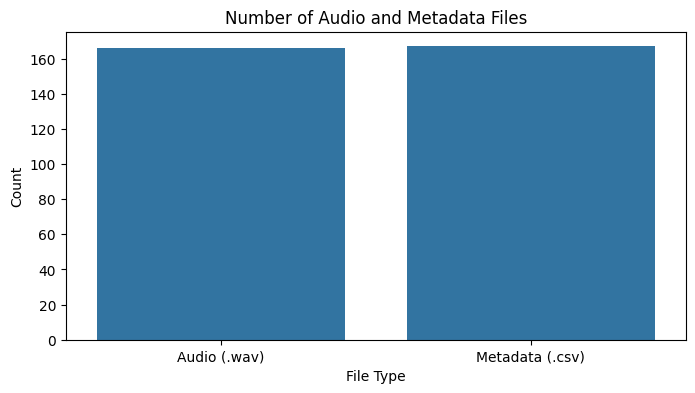


File Counts Table:
         File Type  Count
0     Audio (.wav)    166
1  Metadata (.csv)    167

Metadata Sample:
   Unnamed: 0 adressfname  mmse  dx
0          23    adrso024    20  ad
1          24    adrso025    11  ad
2          25    adrso027    18  ad
3          26    adrso028    18  ad
4          28    adrso031    26  ad

MMSE Score Statistics:
count    166.000000
mean      22.933735
std        6.992754
min        3.000000
25%       17.250000
50%       26.000000
75%       29.000000
max       30.000000
Name: mmse, dtype: float64

Metadata Columns: ['Unnamed: 0', 'adressfname', 'mmse', 'dx']

Unique dx values: ['ad' 'cn']


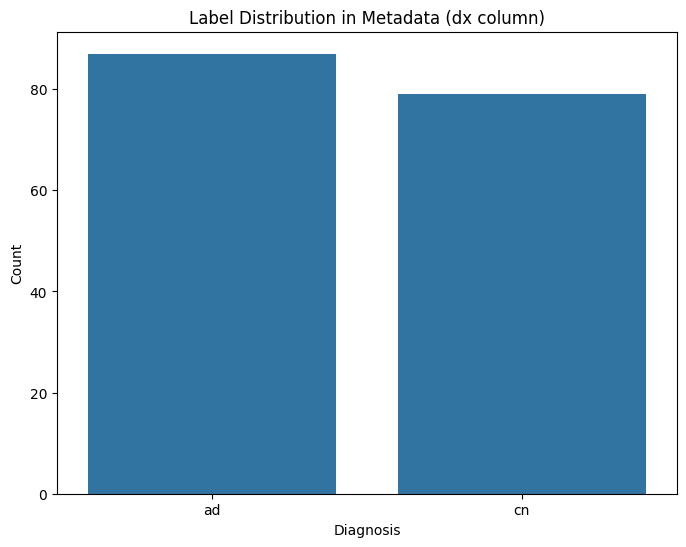

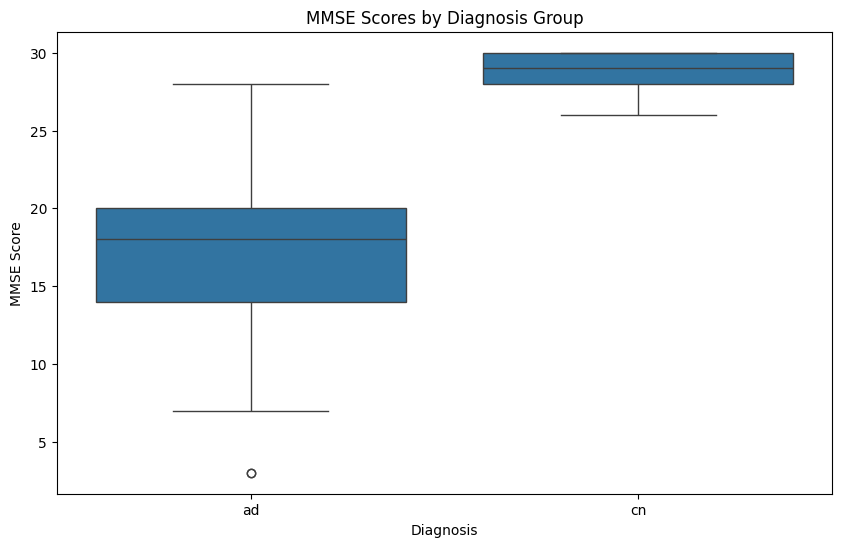


Metadata saved to /content/metadata_sample.csv

Matched 166 audio files with metadata

Matched Audio Metadata Sample:
                                                file label  mmse adressfname
0  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    15    adrso060
1  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    24    adrso247
2  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    17    adrso125
3  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    12    adrso092
4  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    12    adrso116


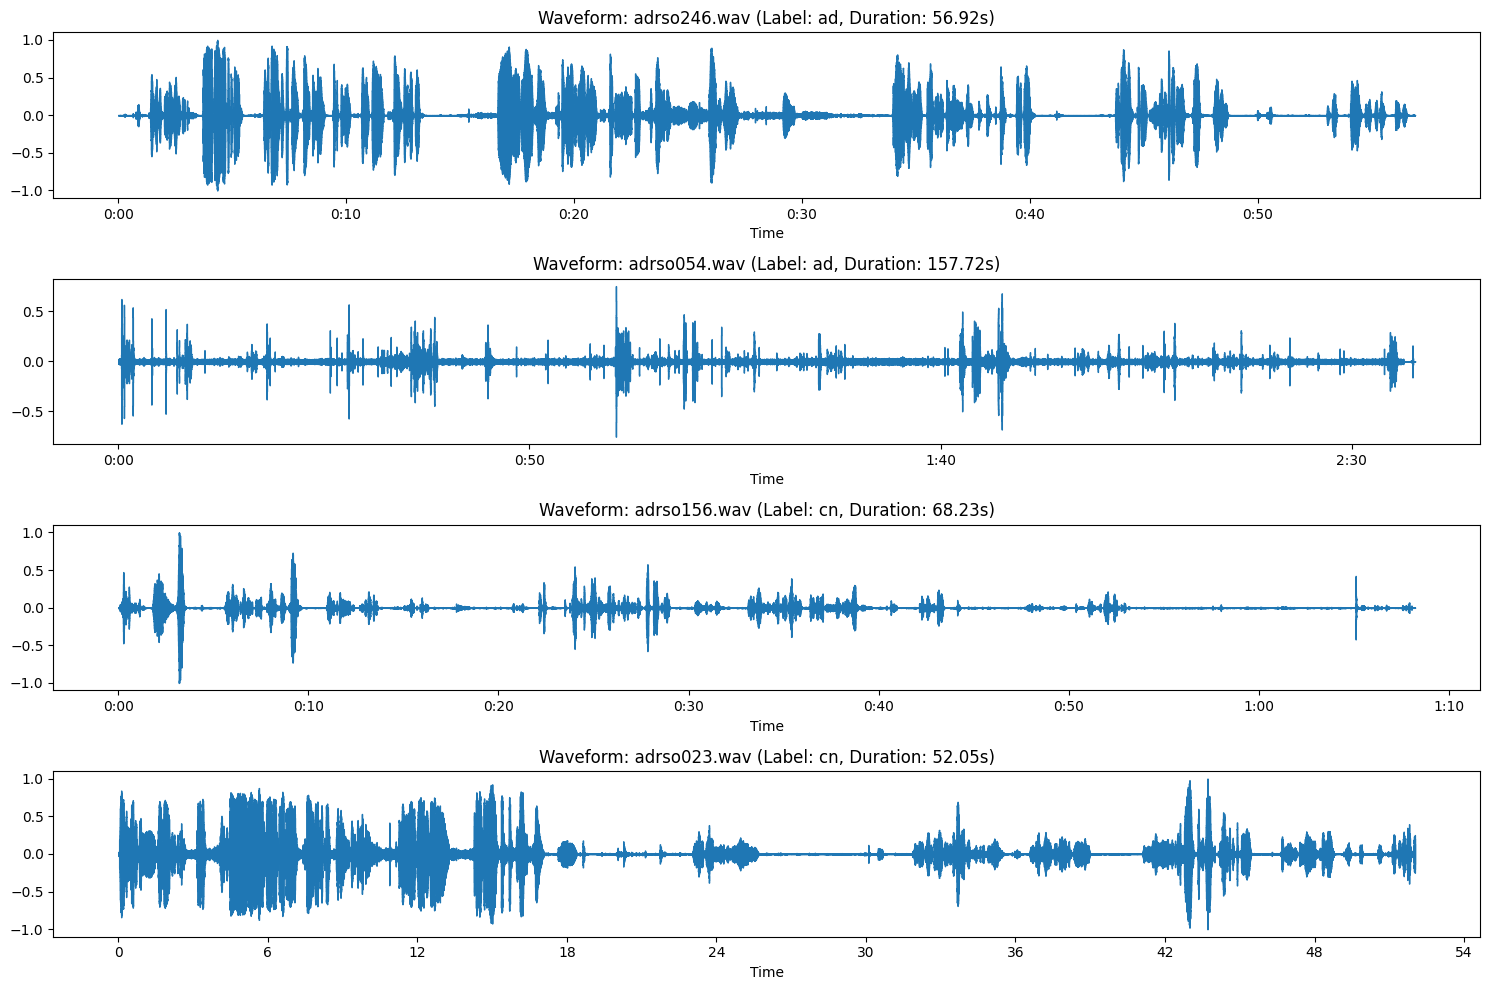

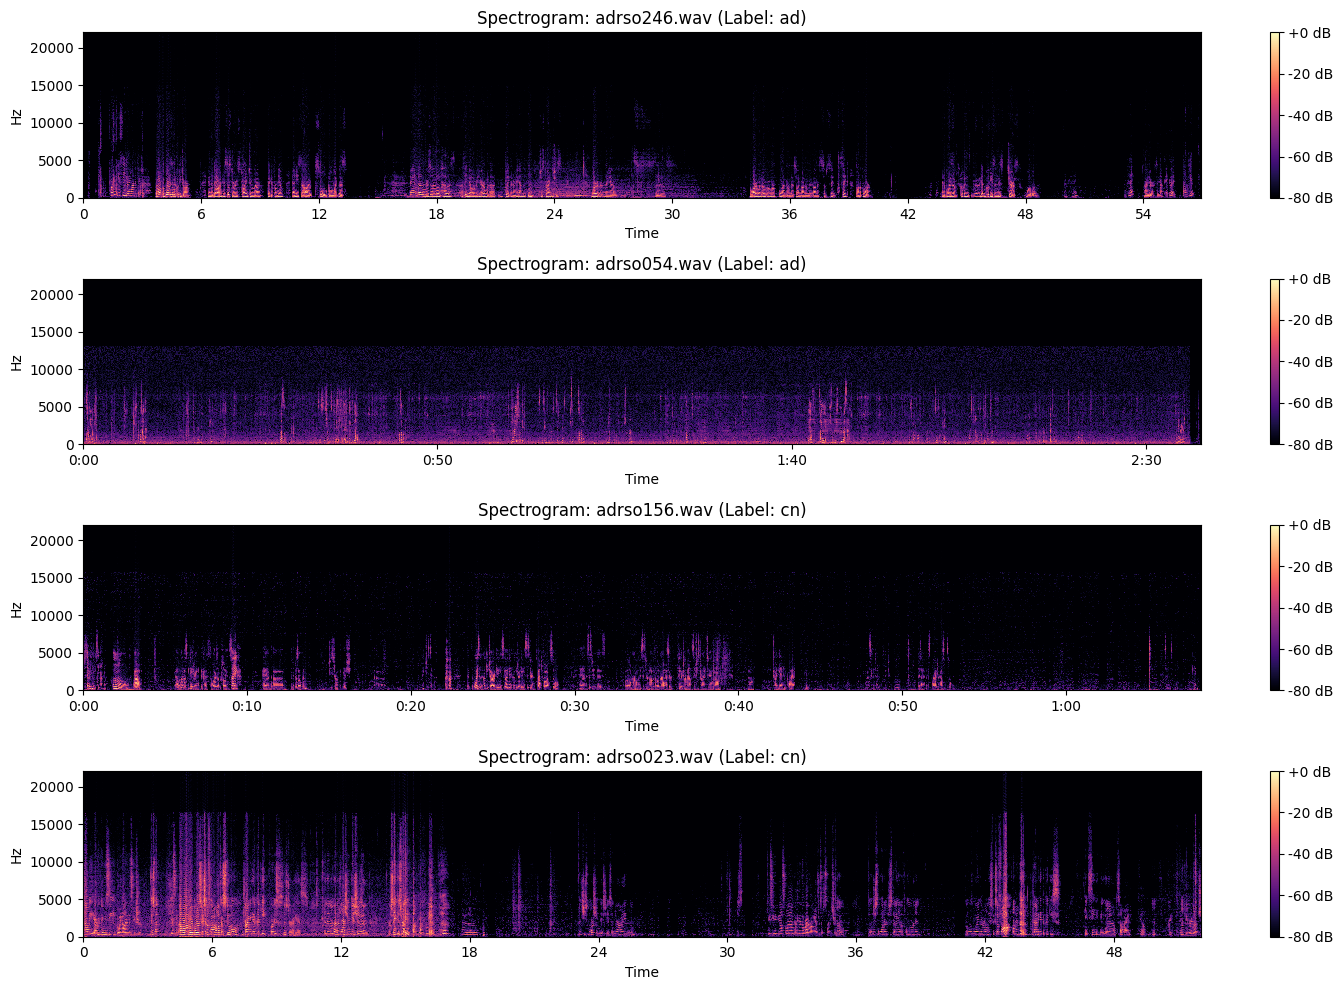


Sample Metadata Table:
                                                file label  mmse
0  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    14
1  /content/extracted_audio/ADReSSo21/diagnosis/t...    ad    12
2  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn    29
3  /content/extracted_audio/ADReSSo21/diagnosis/t...    cn    26

Processing 158 files for feature extraction (79 AD, 79 CN).


Processing audio files:   1%|          | 1/158 [00:00<01:40,  1.57it/s]

Processed: adrso291.wav (Label: cn, MMSE: 28)


Processing audio files:   1%|▏         | 2/158 [00:01<02:31,  1.03it/s]

Processed: adrso049.wav (Label: ad, MMSE: 18)


Processing audio files:   2%|▏         | 3/158 [00:02<02:05,  1.23it/s]

Processed: adrso167.wav (Label: cn, MMSE: 27)


Processing audio files:   3%|▎         | 4/158 [00:02<01:39,  1.54it/s]

Processed: adrso178.wav (Label: cn, MMSE: 28)


Processing audio files:   3%|▎         | 5/158 [00:03<01:14,  2.05it/s]

Processed: adrso007.wav (Label: cn, MMSE: 30)


Processing audio files:   4%|▍         | 6/158 [00:03<01:21,  1.86it/s]

Processed: adrso033.wav (Label: ad, MMSE: 3)


Processing audio files:   4%|▍         | 7/158 [00:03<01:08,  2.22it/s]

Processed: adrso278.wav (Label: cn, MMSE: 28)


Processing audio files:   5%|▌         | 8/158 [00:04<01:15,  1.97it/s]

Processed: adrso162.wav (Label: cn, MMSE: 27)


Processing audio files:   6%|▌         | 9/158 [00:04<01:09,  2.15it/s]

Processed: adrso160.wav (Label: cn, MMSE: 30)


Processing audio files:   6%|▋         | 10/158 [00:05<00:59,  2.48it/s]

Processed: adrso022.wav (Label: cn, MMSE: 27)


Processing audio files:   7%|▋         | 11/158 [00:05<01:03,  2.31it/s]

Processed: adrso228.wav (Label: ad, MMSE: 23)


Processing audio files:   8%|▊         | 12/158 [00:06<01:37,  1.50it/s]

Processed: adrso200.wav (Label: ad, MMSE: 19)


Processing audio files:   8%|▊         | 13/158 [00:07<01:38,  1.47it/s]

Processed: adrso039.wav (Label: ad, MMSE: 10)


Processing audio files:   9%|▉         | 14/158 [00:09<02:30,  1.04s/it]

Processed: adrso054.wav (Label: ad, MMSE: 12)


Processing audio files:   9%|▉         | 15/158 [00:10<02:15,  1.06it/s]

Processed: adrso070.wav (Label: ad, MMSE: 19)


Processing audio files:  10%|█         | 16/158 [00:11<02:12,  1.07it/s]

Processed: adrso206.wav (Label: ad, MMSE: 17)


Processing audio files:  11%|█▏        | 18/158 [00:11<01:27,  1.59it/s]

Processed: adrso260.wav (Label: cn, MMSE: 27)
Processed: adrso010.wav (Label: cn, MMSE: 29)


Processing audio files:  12%|█▏        | 19/158 [00:12<01:18,  1.78it/s]

Processed: adrso023.wav (Label: cn, MMSE: 26)


Processing audio files:  13%|█▎        | 20/158 [00:12<01:16,  1.79it/s]

Processed: adrso093.wav (Label: ad, MMSE: 13)


Processing audio files:  13%|█▎        | 21/158 [00:13<01:29,  1.54it/s]

Processed: adrso280.wav (Label: cn, MMSE: 29)


Processing audio files:  14%|█▍        | 22/158 [00:14<01:19,  1.70it/s]

Processed: adrso122.wav (Label: ad, MMSE: 14)


Processing audio files:  15%|█▍        | 23/158 [00:14<01:15,  1.79it/s]

Processed: adrso126.wav (Label: ad, MMSE: 18)


Processing audio files:  15%|█▌        | 24/158 [00:16<02:01,  1.10it/s]

Processed: adrso045.wav (Label: ad, MMSE: 13)


Processing audio files:  16%|█▌        | 25/158 [00:16<01:40,  1.32it/s]

Processed: adrso236.wav (Label: ad, MMSE: 18)


Processing audio files:  16%|█▋        | 26/158 [00:17<01:31,  1.44it/s]

Processed: adrso157.wav (Label: cn, MMSE: 29)


Processing audio files:  17%|█▋        | 27/158 [00:18<01:32,  1.41it/s]

Processed: adrso055.wav (Label: ad, MMSE: 17)


Processing audio files:  18%|█▊        | 28/158 [00:18<01:37,  1.33it/s]

Processed: adrso164.wav (Label: cn, MMSE: 29)


Processing audio files:  18%|█▊        | 29/158 [00:19<01:34,  1.37it/s]

Processed: adrso168.wav (Label: cn, MMSE: 30)


Processing audio files:  19%|█▉        | 30/158 [00:20<01:29,  1.42it/s]

Processed: adrso268.wav (Label: cn, MMSE: 30)


Processing audio files:  20%|█▉        | 31/158 [00:20<01:25,  1.49it/s]

Processed: adrso002.wav (Label: cn, MMSE: 26)


Processing audio files:  20%|██        | 32/158 [00:21<01:16,  1.65it/s]

Processed: adrso247.wav (Label: ad, MMSE: 24)


Processing audio files:  21%|██        | 33/158 [00:21<01:16,  1.64it/s]

Processed: adrso012.wav (Label: cn, MMSE: 29)


Processing audio files:  22%|██▏       | 34/158 [00:22<01:26,  1.44it/s]

Processed: adrso233.wav (Label: ad, MMSE: 21)


Processing audio files:  22%|██▏       | 35/158 [00:23<01:19,  1.55it/s]

Processed: adrso008.wav (Label: cn, MMSE: 29)


Processing audio files:  23%|██▎       | 36/158 [00:23<01:16,  1.60it/s]

Processed: adrso154.wav (Label: cn, MMSE: 30)


Processing audio files:  23%|██▎       | 37/158 [00:24<01:07,  1.80it/s]

Processed: adrso170.wav (Label: cn, MMSE: 29)


Processing audio files:  24%|██▍       | 38/158 [00:25<01:15,  1.59it/s]

Processed: adrso187.wav (Label: ad, MMSE: 11)


Processing audio files:  25%|██▍       | 39/158 [00:25<01:18,  1.52it/s]

Processed: adrso098.wav (Label: ad, MMSE: 17)


Processing audio files:  25%|██▌       | 40/158 [00:26<01:05,  1.80it/s]

Processed: adrso186.wav (Label: cn, MMSE: 26)


Processing audio files:  26%|██▌       | 41/158 [00:26<01:13,  1.59it/s]

Processed: adrso223.wav (Label: ad, MMSE: 17)


Processing audio files:  27%|██▋       | 42/158 [00:27<01:05,  1.77it/s]

Processed: adrso286.wav (Label: cn, MMSE: 28)


Processing audio files:  27%|██▋       | 43/158 [00:27<00:58,  1.96it/s]

Processed: adrso125.wav (Label: ad, MMSE: 17)


Processing audio files:  28%|██▊       | 44/158 [00:28<00:59,  1.93it/s]

Processed: adrso299.wav (Label: cn, MMSE: 26)


Processing audio files:  28%|██▊       | 45/158 [00:28<00:56,  2.02it/s]

Processed: adrso112.wav (Label: ad, MMSE: 16)


Processing audio files:  29%|██▉       | 46/158 [00:29<01:02,  1.80it/s]

Processed: adrso197.wav (Label: ad, MMSE: 20)


Processing audio files:  30%|██▉       | 47/158 [00:29<00:59,  1.88it/s]

Processed: adrso234.wav (Label: ad, MMSE: 22)


Processing audio files:  30%|███       | 48/158 [00:31<01:20,  1.36it/s]

Processed: adrso274.wav (Label: cn, MMSE: 30)


Processing audio files:  31%|███       | 49/158 [00:31<01:06,  1.63it/s]

Processed: adrso262.wav (Label: cn, MMSE: 29)


Processing audio files:  32%|███▏      | 50/158 [00:32<01:23,  1.30it/s]

Processed: adrso190.wav (Label: ad, MMSE: 20)


Processing audio files:  32%|███▏      | 51/158 [00:33<01:20,  1.33it/s]

Processed: adrso259.wav (Label: cn, MMSE: 30)


Processing audio files:  33%|███▎      | 52/158 [00:34<01:34,  1.12it/s]

Processed: adrso209.wav (Label: ad, MMSE: 17)


Processing audio files:  34%|███▎      | 53/158 [00:35<01:32,  1.14it/s]

Processed: adrso296.wav (Label: cn, MMSE: 30)


Processing audio files:  34%|███▍      | 54/158 [00:35<01:23,  1.24it/s]

Processed: adrso123.wav (Label: ad, MMSE: 26)


Processing audio files:  35%|███▍      | 55/158 [00:36<01:15,  1.36it/s]

Processed: adrso292.wav (Label: cn, MMSE: 28)


Processing audio files:  35%|███▌      | 56/158 [00:37<01:15,  1.36it/s]

Processed: adrso257.wav (Label: cn, MMSE: 30)


Processing audio files:  36%|███▌      | 57/158 [00:38<01:14,  1.35it/s]

Processed: adrso063.wav (Label: ad, MMSE: 13)


Processing audio files:  37%|███▋      | 58/158 [00:39<01:26,  1.16it/s]

Processed: adrso215.wav (Label: ad, MMSE: 14)


Processing audio files:  37%|███▋      | 59/158 [00:40<01:24,  1.18it/s]

Processed: adrso031.wav (Label: ad, MMSE: 26)


Processing audio files:  38%|███▊      | 60/158 [00:40<01:17,  1.27it/s]

Processed: adrso106.wav (Label: ad, MMSE: 17)


Processing audio files:  39%|███▊      | 61/158 [00:41<01:14,  1.30it/s]

Processed: adrso172.wav (Label: cn, MMSE: 30)


Processing audio files:  39%|███▉      | 62/158 [00:41<01:03,  1.51it/s]

Processed: adrso246.wav (Label: ad, MMSE: 14)


Processing audio files:  40%|███▉      | 63/158 [00:43<01:42,  1.08s/it]

Processed: adrso024.wav (Label: ad, MMSE: 20)


Processing audio files:  41%|████      | 64/158 [00:44<01:26,  1.09it/s]

Processed: adrso173.wav (Label: cn, MMSE: 30)


Processing audio files:  41%|████      | 65/158 [00:45<01:20,  1.16it/s]

Processed: adrso244.wav (Label: ad, MMSE: 11)


Processing audio files:  42%|████▏     | 66/158 [00:45<01:12,  1.27it/s]

Processed: adrso261.wav (Label: cn, MMSE: 29)


Processing audio files:  42%|████▏     | 67/158 [00:46<01:09,  1.30it/s]

Processed: adrso148.wav (Label: cn, MMSE: 30)


Processing audio files:  43%|████▎     | 68/158 [00:46<01:02,  1.44it/s]

Processed: adrso224.wav (Label: ad, MMSE: 17)


Processing audio files:  44%|████▎     | 69/158 [00:47<00:54,  1.64it/s]

Processed: adrso267.wav (Label: cn, MMSE: 30)


Processing audio files:  44%|████▍     | 70/158 [00:47<00:51,  1.70it/s]

Processed: adrso138.wav (Label: ad, MMSE: 12)


Processing audio files:  45%|████▍     | 71/158 [00:48<00:43,  1.99it/s]

Processed: adrso092.wav (Label: ad, MMSE: 12)


Processing audio files:  46%|████▌     | 72/158 [00:49<00:54,  1.58it/s]

Processed: adrso265.wav (Label: cn, MMSE: 30)


Processing audio files:  46%|████▌     | 73/158 [00:49<00:51,  1.66it/s]

Processed: adrso237.wav (Label: ad, MMSE: 20)


Processing audio files:  47%|████▋     | 74/158 [00:50<00:47,  1.75it/s]

Processed: adrso245.wav (Label: ad, MMSE: 10)


Processing audio files:  47%|████▋     | 75/158 [00:51<00:53,  1.56it/s]

Processed: adrso158.wav (Label: cn, MMSE: 30)


Processing audio files:  48%|████▊     | 76/158 [00:52<01:15,  1.08it/s]

Processed: adrso212.wav (Label: ad, MMSE: 28)


Processing audio files:  49%|████▊     | 77/158 [00:53<01:02,  1.29it/s]

Processed: adrso036.wav (Label: ad, MMSE: 10)


Processing audio files:  49%|████▉     | 78/158 [00:53<00:56,  1.41it/s]

Processed: adrso316.wav (Label: cn, MMSE: 30)


Processing audio files:  50%|█████     | 79/158 [00:57<02:02,  1.55s/it]

Processed: adrso056.wav (Label: ad, MMSE: 28)


Processing audio files:  51%|█████     | 80/158 [00:57<01:38,  1.27s/it]

Processed: adrso264.wav (Label: cn, MMSE: 29)


Processing audio files:  51%|█████▏    | 81/158 [00:58<01:17,  1.01s/it]

Processed: adrso263.wav (Label: cn, MMSE: 28)


Processing audio files:  52%|█████▏    | 82/158 [00:58<01:04,  1.19it/s]

Processed: adrso005.wav (Label: cn, MMSE: 27)


Processing audio files:  53%|█████▎    | 83/158 [00:58<00:50,  1.50it/s]

Processed: adrso003.wav (Label: cn, MMSE: 30)


Processing audio files:  53%|█████▎    | 84/158 [00:59<00:45,  1.61it/s]

Processed: adrso189.wav (Label: ad, MMSE: 19)


Processing audio files:  54%|█████▍    | 85/158 [00:59<00:44,  1.62it/s]

Processed: adrso308.wav (Label: cn, MMSE: 30)


Processing audio files:  54%|█████▍    | 86/158 [01:01<00:56,  1.27it/s]

Processed: adrso220.wav (Label: ad, MMSE: 20)


Processing audio files:  55%|█████▌    | 87/158 [01:01<00:46,  1.53it/s]

Processed: adrso134.wav (Label: ad, MMSE: 8)


Processing audio files:  56%|█████▌    | 88/158 [01:03<01:15,  1.08s/it]

Processed: adrso216.wav (Label: ad, MMSE: 24)


Processing audio files:  56%|█████▋    | 89/158 [01:04<01:09,  1.01s/it]

Processed: adrso312.wav (Label: cn, MMSE: 29)


Processing audio files:  57%|█████▋    | 90/158 [01:05<01:04,  1.06it/s]

Processed: adrso021.wav (Label: cn, MMSE: 28)


Processing audio files:  58%|█████▊    | 91/158 [01:06<01:01,  1.09it/s]

Processed: adrso182.wav (Label: cn, MMSE: 29)


Processing audio files:  58%|█████▊    | 92/158 [01:07<01:04,  1.02it/s]

Processed: adrso229.wav (Label: ad, MMSE: 10)


Processing audio files:  59%|█████▉    | 93/158 [01:07<00:50,  1.30it/s]

Processed: adrso300.wav (Label: cn, MMSE: 28)


Processing audio files:  59%|█████▉    | 94/158 [01:07<00:40,  1.58it/s]

Processed: adrso016.wav (Label: cn, MMSE: 29)


Processing audio files:  60%|██████    | 95/158 [01:08<00:42,  1.50it/s]

Processed: adrso035.wav (Label: ad, MMSE: 24)


Processing audio files:  61%|██████    | 96/158 [01:09<00:38,  1.61it/s]

Processed: adrso074.wav (Label: ad, MMSE: 24)


Processing audio files:  61%|██████▏   | 97/158 [01:09<00:34,  1.79it/s]

Processed: adrso165.wav (Label: cn, MMSE: 30)


Processing audio files:  62%|██████▏   | 98/158 [01:09<00:33,  1.81it/s]

Processed: adrso015.wav (Label: cn, MMSE: 29)


Processing audio files:  63%|██████▎   | 99/158 [01:10<00:33,  1.78it/s]

Processed: adrso144.wav (Label: ad, MMSE: 13)


Processing audio files:  63%|██████▎   | 100/158 [01:11<00:32,  1.81it/s]

Processed: adrso028.wav (Label: ad, MMSE: 18)


Processing audio files:  64%|██████▍   | 101/158 [01:11<00:33,  1.72it/s]

Processed: adrso270.wav (Label: cn, MMSE: 30)


Processing audio files:  65%|██████▍   | 102/158 [01:12<00:34,  1.62it/s]

Processed: adrso128.wav (Label: ad, MMSE: 20)


Processing audio files:  65%|██████▌   | 103/158 [01:12<00:32,  1.69it/s]

Processed: adrso205.wav (Label: ad, MMSE: 15)


Processing audio files:  66%|██████▌   | 104/158 [01:13<00:28,  1.91it/s]

Processed: adrso059.wav (Label: ad, MMSE: 20)


Processing audio files:  66%|██████▋   | 105/158 [01:13<00:30,  1.76it/s]

Processed: adrso109.wav (Label: ad, MMSE: 20)


Processing audio files:  67%|██████▋   | 106/158 [01:14<00:28,  1.80it/s]

Processed: adrso211.wav (Label: ad, MMSE: 15)


Processing audio files:  68%|██████▊   | 107/158 [01:14<00:25,  2.01it/s]

Processed: adrso089.wav (Label: ad, MMSE: 10)


Processing audio files:  68%|██████▊   | 108/158 [01:15<00:25,  1.99it/s]

Processed: adrso307.wav (Label: cn, MMSE: 29)


Processing audio files:  69%|██████▉   | 109/158 [01:15<00:23,  2.11it/s]

Processed: adrso310.wav (Label: cn, MMSE: 28)


Processing audio files:  70%|██████▉   | 110/158 [01:16<00:22,  2.12it/s]

Processed: adrso014.wav (Label: cn, MMSE: 30)


Processing audio files:  70%|███████   | 111/158 [01:16<00:22,  2.07it/s]

Processed: adrso315.wav (Label: cn, MMSE: 28)


Processing audio files:  71%|███████   | 112/158 [01:17<00:21,  2.10it/s]

Processed: adrso285.wav (Label: cn, MMSE: 30)


Processing audio files:  72%|███████▏  | 113/158 [01:17<00:23,  1.89it/s]

Processed: adrso156.wav (Label: cn, MMSE: 29)


Processing audio files:  72%|███████▏  | 114/158 [01:19<00:34,  1.28it/s]

Processed: adrso116.wav (Label: ad, MMSE: 12)


Processing audio files:  73%|███████▎  | 115/158 [01:20<00:33,  1.29it/s]

Processed: adrso289.wav (Label: cn, MMSE: 30)


Processing audio files:  73%|███████▎  | 116/158 [01:20<00:31,  1.33it/s]

Processed: adrso071.wav (Label: ad, MMSE: 23)


Processing audio files:  74%|███████▍  | 117/158 [01:21<00:30,  1.33it/s]

Processed: adrso027.wav (Label: ad, MMSE: 18)


Processing audio files:  75%|███████▍  | 118/158 [01:21<00:24,  1.61it/s]

Processed: adrso169.wav (Label: cn, MMSE: 30)


Processing audio files:  75%|███████▌  | 119/158 [01:22<00:21,  1.78it/s]

Processed: adrso047.wav (Label: ad, MMSE: 19)


Processing audio files:  76%|███████▌  | 120/158 [01:22<00:21,  1.73it/s]

Processed: adrso188.wav (Label: ad, MMSE: 23)


Processing audio files:  77%|███████▋  | 121/158 [01:23<00:19,  1.95it/s]

Processed: adrso222.wav (Label: ad, MMSE: 16)


Processing audio files:  77%|███████▋  | 122/158 [01:23<00:19,  1.87it/s]

Processed: adrso232.wav (Label: ad, MMSE: 20)


Processing audio files:  78%|███████▊  | 123/158 [01:24<00:17,  1.99it/s]

Processed: adrso266.wav (Label: cn, MMSE: 30)


Processing audio files:  78%|███████▊  | 124/158 [01:24<00:15,  2.26it/s]

Processed: adrso072.wav (Label: ad, MMSE: 19)


Processing audio files:  79%|███████▉  | 125/158 [01:24<00:12,  2.57it/s]

Processed: adrso161.wav (Label: cn, MMSE: 29)


Processing audio files:  80%|███████▉  | 126/158 [01:25<00:13,  2.45it/s]

Processed: adrso180.wav (Label: cn, MMSE: 29)


Processing audio files:  80%|████████  | 127/158 [01:25<00:13,  2.24it/s]

Processed: adrso250.wav (Label: ad, MMSE: 15)


Processing audio files:  81%|████████  | 128/158 [01:26<00:14,  2.02it/s]

Processed: adrso283.wav (Label: cn, MMSE: 30)


Processing audio files:  82%|████████▏ | 129/158 [01:26<00:14,  1.99it/s]

Processed: adrso110.wav (Label: ad, MMSE: 14)


Processing audio files:  82%|████████▏ | 130/158 [01:27<00:13,  2.04it/s]

Processed: adrso218.wav (Label: ad, MMSE: 27)


Processing audio files:  83%|████████▎ | 131/158 [01:27<00:12,  2.11it/s]

Processed: adrso273.wav (Label: cn, MMSE: 30)


Processing audio files:  84%|████████▎ | 132/158 [01:28<00:17,  1.52it/s]

Processed: adrso202.wav (Label: ad, MMSE: 23)


Processing audio files:  84%|████████▍ | 133/158 [01:29<00:14,  1.73it/s]

Processed: adrso159.wav (Label: cn, MMSE: 29)


Processing audio files:  85%|████████▍ | 134/158 [01:29<00:11,  2.01it/s]

Processed: adrso141.wav (Label: ad, MMSE: 20)


Processing audio files:  85%|████████▌ | 135/158 [01:30<00:14,  1.55it/s]

Processed: adrso198.wav (Label: ad, MMSE: 7)


Processing audio files:  86%|████████▌ | 136/158 [01:31<00:14,  1.54it/s]

Processed: adrso298.wav (Label: cn, MMSE: 30)


Processing audio files:  87%|████████▋ | 137/158 [01:32<00:16,  1.31it/s]

Processed: adrso032.wav (Label: ad, MMSE: 25)


Processing audio files:  87%|████████▋ | 138/158 [01:33<00:16,  1.19it/s]

Processed: adrso090.wav (Label: ad, MMSE: 25)


Processing audio files:  88%|████████▊ | 139/158 [01:34<00:15,  1.21it/s]

Processed: adrso277.wav (Label: cn, MMSE: 29)


Processing audio files:  89%|████████▊ | 140/158 [01:34<00:13,  1.33it/s]

Processed: adrso019.wav (Label: cn, MMSE: 30)


Processing audio files:  89%|████████▉ | 141/158 [01:34<00:10,  1.65it/s]

Processed: adrso130.wav (Label: ad, MMSE: 17)


Processing audio files:  90%|████████▉ | 142/158 [01:35<00:10,  1.53it/s]

Processed: adrso183.wav (Label: cn, MMSE: 30)


Processing audio files:  91%|█████████ | 143/158 [01:36<00:08,  1.70it/s]

Processed: adrso060.wav (Label: ad, MMSE: 15)


Processing audio files:  91%|█████████ | 144/158 [01:37<00:10,  1.35it/s]

Processed: adrso192.wav (Label: ad, MMSE: 3)


Processing audio files:  92%|█████████▏| 145/158 [01:37<00:08,  1.53it/s]

Processed: adrso309.wav (Label: cn, MMSE: 30)


Processing audio files:  92%|█████████▏| 146/158 [01:39<00:10,  1.12it/s]

Processed: adrso276.wav (Label: cn, MMSE: 29)


Processing audio files:  93%|█████████▎| 147/158 [01:39<00:09,  1.15it/s]

Processed: adrso153.wav (Label: cn, MMSE: 30)


Processing audio files:  94%|█████████▎| 148/158 [01:40<00:07,  1.29it/s]

Processed: adrso281.wav (Label: cn, MMSE: 28)


Processing audio files:  94%|█████████▍| 149/158 [01:40<00:06,  1.43it/s]

Processed: adrso018.wav (Label: cn, MMSE: 29)


Processing audio files:  95%|█████████▍| 150/158 [01:42<00:07,  1.07it/s]

Processed: adrso078.wav (Label: ad, MMSE: 22)


Processing audio files:  96%|█████████▌| 151/158 [01:43<00:05,  1.22it/s]

Processed: adrso017.wav (Label: cn, MMSE: 30)


Processing audio files:  96%|█████████▌| 152/158 [01:43<00:04,  1.37it/s]

Processed: adrso151.wav (Label: cn, MMSE: 28)


Processing audio files:  97%|█████████▋| 153/158 [01:43<00:03,  1.63it/s]

Processed: adrso249.wav (Label: ad, MMSE: 20)


Processing audio files:  97%|█████████▋| 154/158 [01:44<00:02,  1.41it/s]

Processed: adrso046.wav (Label: ad, MMSE: 15)


Processing audio files:  98%|█████████▊| 155/158 [01:45<00:02,  1.29it/s]

Processed: adrso302.wav (Label: cn, MMSE: 29)


Processing audio files:  99%|█████████▊| 156/158 [01:46<00:01,  1.41it/s]

Processed: adrso068.wav (Label: ad, MMSE: 20)


Processing audio files:  99%|█████████▉| 157/158 [01:46<00:00,  1.43it/s]

Processed: adrso152.wav (Label: cn, MMSE: 30)


Processing audio files: 100%|██████████| 158/158 [01:47<00:00,  1.46it/s]

Processed: adrso177.wav (Label: cn, MMSE: 28)

Extracted features shape: (158, 32)
Labels shape: (158,)


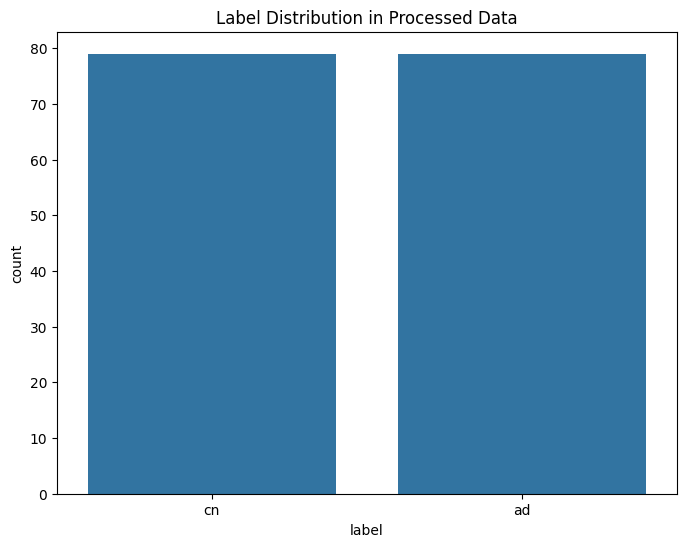


Processed Metadata Sample:
                                       file label  mmse
0  /content/processed_features/adrso291.wav    cn    28
1  /content/processed_features/adrso049.wav    ad    18
2  /content/processed_features/adrso167.wav    cn    27
3  /content/processed_features/adrso178.wav    cn    28
4  /content/processed_features/adrso007.wav    cn    30


In [41]:
# Complete Alzheimer's Voice Detection Pipeline

# Step 1: Data Loading and Preparation
import os
import tarfile
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import soundfile as sf

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define paths
data_path = '/content/drive/MyDrive/Voice/'
extracted_path = '/content/extracted_audio/'
os.makedirs(extracted_path, exist_ok=True)

# .tgz file path - ADReSSo21 dataset for Alzheimer's detection from voice
tgz_file = os.path.join(data_path, 'ADReSSo21-diagnosis-train.tgz')

# Validate file existence
if not os.path.exists(tgz_file):
    print(f"Error: File {tgz_file} not found.")
    print("\nPlease verify the file name and path. Run the following to check:")
    print("!ls -l /content/drive/MyDrive/Voice/")
    print("\nProceeding with dummy data for demonstration.")
    # Create dummy audio files
    dummy_audio_dir = '/content/dummy_audio/'
    os.makedirs(dummy_audio_dir, exist_ok=True)
    for i in range(1, 11):
        y = np.random.randn(16000 * 5)  # 5 seconds of random noise
        sf.write(os.path.join(dummy_audio_dir, f'adrso{i:03d}.wav'), y, 16000)
    audio_files = glob.glob(os.path.join(dummy_audio_dir, '*.wav'))
    csv_files = []
else:
    # Check file size before extraction
    file_size_mb = os.path.getsize(tgz_file) / (1024 * 1024)
    print(f"File size: {file_size_mb:.2f} MB")

    # Extract .tgz file
    try:
        with tarfile.open(tgz_file, 'r:gz') as tar:
            tar.extractall(path=extracted_path)
        print(f"Successfully extracted {tgz_file} to {extracted_path}")
    except Exception as e:
        print(f"Error extracting {tgz_file}: {str(e)}")
        audio_files = []
        csv_files = []
    else:
        audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
        csv_files = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)

print(f"Found {len(audio_files)} audio files and {len(csv_files)} CSV files.")

# Visualization: File counts
file_counts = pd.DataFrame({
    'File Type': ['Audio (.wav)', 'Metadata (.csv)'],
    'Count': [len(audio_files), len(csv_files)]
})
plt.figure(figsize=(8, 4))
sns.barplot(data=file_counts, x='File Type', y='Count')
plt.title('Number of Audio and Metadata Files')
plt.savefig('/content/file_counts.png')
plt.show()
print("\nFile Counts Table:")
print(file_counts)

# Step 2: Metadata Analysis
# Load metadata
csv_files = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
if csv_files:
    metadata = pd.read_csv(csv_files[0])  # Load first CSV
    print("\nMetadata Sample:")
    print(metadata.head())
    metadata['adressfname'] = metadata['adressfname'].astype(str).str.strip().str.lower()
    metadata['dx'] = metadata['dx'].astype(str).str.strip().str.lower()

    # Add MMSE score statistics
    mmse_stats = metadata['mmse'].describe()
    print("\nMMSE Score Statistics:")
    print(mmse_stats)
else:
    print("No metadata CSV found. Using dummy metadata.")
    metadata = pd.DataFrame({
        'adressfname': [f'adrso{i:03d}' for i in range(1, 11)],
        'dx': ['ad' if i % 2 == 0 else 'cn' for i in range(1, 11)],
        'mmse': [20 + i for i in range(10)]
    })
    metadata.to_csv(os.path.join(dummy_audio_dir, 'dummy_metadata.csv'), index=False)

# Debugging: Inspect metadata
print("\nMetadata Columns:", metadata.columns.tolist())
print("\nUnique dx values:", metadata['dx'].unique())

# Visualization: Label distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=metadata, x='dx')
plt.title('Label Distribution in Metadata (dx column)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.savefig('/content/label_distribution.png')
plt.show()

# Visualization: MMSE score distribution by diagnosis
plt.figure(figsize=(10, 6))
sns.boxplot(data=metadata, x='dx', y='mmse')
plt.title('MMSE Scores by Diagnosis Group')
plt.xlabel('Diagnosis')
plt.ylabel('MMSE Score')
plt.savefig('/content/mmse_by_diagnosis.png')
plt.show()

# Save metadata for reference
metadata.to_csv('/content/metadata_sample.csv', index=False)
print("\nMetadata saved to /content/metadata_sample.csv")

# Step 2.5: Match audio files with metadata (Missing step from original code)
# Create a dataframe mapping audio files to their metadata
matched_audio_metadata = []

for audio_file in audio_files:
    basename = os.path.basename(audio_file).split('.')[0].lower()
    # Match with metadata
    match = metadata[metadata['adressfname'].str.contains(basename)]
    if not match.empty:
        matched_audio_metadata.append({
            'file': audio_file,
            'label': match.iloc[0]['dx'],
            'mmse': match.iloc[0]['mmse'],
            'adressfname': match.iloc[0]['adressfname']
        })

# Create DataFrame and save
audio_metadata = pd.DataFrame(matched_audio_metadata)
print(f"\nMatched {len(audio_metadata)} audio files with metadata")
print("\nMatched Audio Metadata Sample:")
print(audio_metadata.head())
audio_metadata.to_csv('/content/audio_metadata.csv', index=False)

# Step 3: Audio Visualization
# Load matched metadata
audio_metadata = pd.read_csv('/content/audio_metadata.csv')

# Check if audio_metadata is empty
if audio_metadata.empty:
    print("Warning: No audio files matched with metadata. Using dummy data.")
    audio_metadata = pd.DataFrame({
        'file': [f'/content/dummy_audio/adrso{i:03d}.wav' for i in range(1, 4)],
        'label': ['ad', 'cn', 'ad'],
        'mmse': [20, 22, 24],
        'adressfname': [f'adrso{i:03d}' for i in range(1, 4)]
    })

# Function to get audio duration
def get_audio_duration(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return len(y) / sr

# Select sample files - ensure both classes are represented
sample_ad = audio_metadata[audio_metadata['label'] == 'ad'].sample(min(2, sum(audio_metadata['label'] == 'ad'))).reset_index(drop=True)
sample_cn = audio_metadata[audio_metadata['label'] == 'cn'].sample(min(2, sum(audio_metadata['label'] == 'cn'))).reset_index(drop=True)
samples = pd.concat([sample_ad, sample_cn]).reset_index(drop=True)

import librosa
import librosa.display

# Plot waveforms with duration information
plt.figure(figsize=(15, 10))
for i, row in samples.iterrows():
    audio_file = row['file']
    label = row['label']
    y, sr = librosa.load(audio_file, sr=None)
    duration = len(y) / sr

    plt.subplot(len(samples), 1, i+1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {os.path.basename(audio_file)} (Label: {label}, Duration: {duration:.2f}s)")
plt.tight_layout()
plt.savefig('/content/waveforms.png')
plt.show()

# Plot spectrograms comparing AD and CN samples
plt.figure(figsize=(15, 10))
for i, row in samples.iterrows():
    audio_file = row['file']
    label = row['label']
    y, sr = librosa.load(audio_file, sr=None)

    plt.subplot(len(samples), 1, i+1)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram: {os.path.basename(audio_file)} (Label: {label})")
plt.tight_layout()
plt.savefig('/content/spectrograms_comparison.png')
plt.show()

# Visualization: Sample metadata table
print("\nSample Metadata Table:")
print(samples[['file', 'label', 'mmse']])

# Step 5: Feature Extraction and Processing
import os
import pandas as pd
import librosa
import numpy as np
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
output_dir = '/content/processed_features/'
os.makedirs(output_dir, exist_ok=True)

# Load matched metadata
audio_metadata = pd.read_csv('/content/audio_metadata.csv')

# Ensure both 'ad' and 'cn' labels with balanced representation
ad_samples = audio_metadata[audio_metadata['label'] == 'ad']
cn_samples = audio_metadata[audio_metadata['label'] == 'cn']

# Get the minimum count for balancing
min_count = min(len(ad_samples), len(cn_samples))
subset_size = min(50, 2 * min_count)  # Limit total to 50 if available

# Sample equally from both classes
ad_subset = ad_samples.sample(n=min(min_count, len(ad_samples)), random_state=42)
cn_subset = cn_samples.sample(n=min(min_count, len(cn_samples)), random_state=42)
audio_metadata = pd.concat([ad_subset, cn_subset]).sample(frac=1, random_state=42)  # Shuffle

print(f"\nProcessing {len(audio_metadata)} files for feature extraction ({sum(audio_metadata['label']=='ad')} AD, {sum(audio_metadata['label']=='cn')} CN).")

# Enhanced preprocessing function with additional acoustic features
def process_audio(audio_file, sr=16000):
    y, orig_sr = librosa.load(audio_file, sr=sr, mono=True)

    # Trim silence
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)

    # Basic features
    mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)

    # Pitch and energy
    pitches, magnitudes = librosa.piptrack(y=y_trimmed, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
    energy = np.mean(librosa.feature.rms(y=y_trimmed))

    # Additional acoustic features
    zcr = np.mean(librosa.feature.zero_crossing_rate(y_trimmed))
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y_trimmed, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y_trimmed, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y_trimmed, sr=sr))

    # Combine all features
    features = np.concatenate([
        mfccs_mean,
        mfccs_std,
        [pitch_mean, energy, zcr, spectral_centroid, spectral_bandwidth, spectral_rolloff]
    ])

    return y_trimmed, features

# Process audio files
processed_features = []
processed_audio_paths = []
labels = []
mmse_scores = []

for idx, row in tqdm(audio_metadata.iterrows(), total=len(audio_metadata), desc="Processing audio files"):
    try:
        y_trimmed, features = process_audio(row['file'])
        output_path = os.path.join(output_dir, os.path.basename(row['file']))
        sf.write(output_path, y_trimmed, 16000)
        processed_features.append(features)
        processed_audio_paths.append(output_path)
        labels.append(row['label'])
        mmse_scores.append(row['mmse'])
        print(f"Processed: {os.path.basename(row['file'])} (Label: {row['label']}, MMSE: {row['mmse']})")
    except Exception as e:
        print(f"Error processing {row['file']}: {e}")

# Convert to arrays
processed_features = np.array(processed_features)
labels = np.array(labels)
mmse_scores = np.array(mmse_scores)
print(f"\nExtracted features shape: {processed_features.shape}")
print(f"Labels shape: {labels.shape}")

# Feature names for better visualization
feature_names = (
    [f'MFCC_mean_{i+1}' for i in range(13)] +
    [f'MFCC_std_{i+1}' for i in range(13)] +
    ['Pitch_mean', 'Energy', 'ZeroCrossingRate', 'SpectralCentroid', 'SpectralBandwidth', 'SpectralRolloff']
)

# Save temporary features for next steps
np.save(os.path.join(output_dir, 'features_temp.npy'), processed_features)
np.save(os.path.join(output_dir, 'feature_names.npy'), np.array(feature_names))

# Visualization: Label distribution
processed_metadata = pd.DataFrame({
    'file': processed_audio_paths,
    'label': labels,
    'mmse': mmse_scores
})
plt.figure(figsize=(8, 6))
sns.countplot(data=processed_metadata, x='label')
plt.title('Label Distribution in Processed Data')
plt.savefig('/content/processed_label_distribution.png')
plt.show()
print("\nProcessed Metadata Sample:")
print(processed_metadata.head())

# Save processed metadata
processed_metadata.to_csv(os.path.join(output_dir, 'processed_metadata.csv'), index=False)
